In [1]:
from data_utils import parse_line
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
languages = ["Python", "Java"]
models = ["CodeLlama-70b-hf_ASAP", "CodeLlama-70b-hf_BM25", "deepseek-coder-33b-instruct_ASAP", "deepseek-coder-33b-instruct_BM25", "gpt-3.5-turbo_ASAP", "gpt-3.5-turbo_BM25"]
all_probs = {}
for language in languages:
    all_probs[language] = {}
    for model in models:
        all_probs[language][model] = []
        file_path = f"data/{language}/model_outputs/{model}.txt"
        with open(file_path, "r") as file:
            for line in file:
                if language == "Java" and (model == "gpt-3.5-turbo_ASAP" or model == "gpt-3.5-turbo_BM25"):
                    _, measures = parse_line(line, probs=False)
                else:
                    _, measures = parse_line(line, probs=True)
                if measures:
                    probs = np.exp(measures["log_probs"])
                    all_probs[language][model].append(probs.tolist())

In [2]:
import numpy as np

def geom_mean(probs):
    if len(probs) == 0:
        return 0
    elif len(probs) == 1:
        return probs[0]
    else:
        return np.prod(probs) ** (1 / len(probs))

def get_avg_probs_per_position(probs, target_length_range=(30, 35)):
    max_length = max(len(prob_list) for prob_list in probs if prob_list)
    
    avg_probs = []
    sample_sizes = []
    probs_list_per_postion = []
    lengths = [len(prob_list) for prob_list in probs]

    for i in range(max_length):
        # valid_probs is a list of probabilities for the i-th position
        valid_probs = [prob_list[i] for prob_list in probs if i < len(prob_list) and target_length_range[0] <= len(prob_list) <= target_length_range[1]]
        if valid_probs:
            avg_probs.append(geom_mean(valid_probs))
            probs_list_per_postion.append(valid_probs)
            sample_sizes.append(len(valid_probs))
        # else:
            # avg_probs.append(np.nan)
            # sample_sizes.append(0)
    return avg_probs, sample_sizes, probs_list_per_postion, lengths

prob_info = {}
for language in all_probs:
    prob_info[language] = {}
    for model in all_probs[language]:
        prob_info[language][model] = {}
        avg_probs, sample_sizes, probs_list_per_postion, lengths = get_avg_probs_per_position(all_probs[language][model], target_length_range=(0, 100))
        prob_info[language][model]["avg_probs"] = avg_probs
        prob_info[language][model]["sample_sizes"] = sample_sizes
        prob_info[language][model]["probs_list_per_postion"] = probs_list_per_postion
        prob_info[language][model]["lengths"] = lengths
        # print(f"Language: {language}, Model: {model}")
        # print(f"Average probabilities: {avg_probs}")
        # print(f"Sample sizes: {sample_sizes}")
        # print(f"Probs list per position: {probs_list_per_postion}")


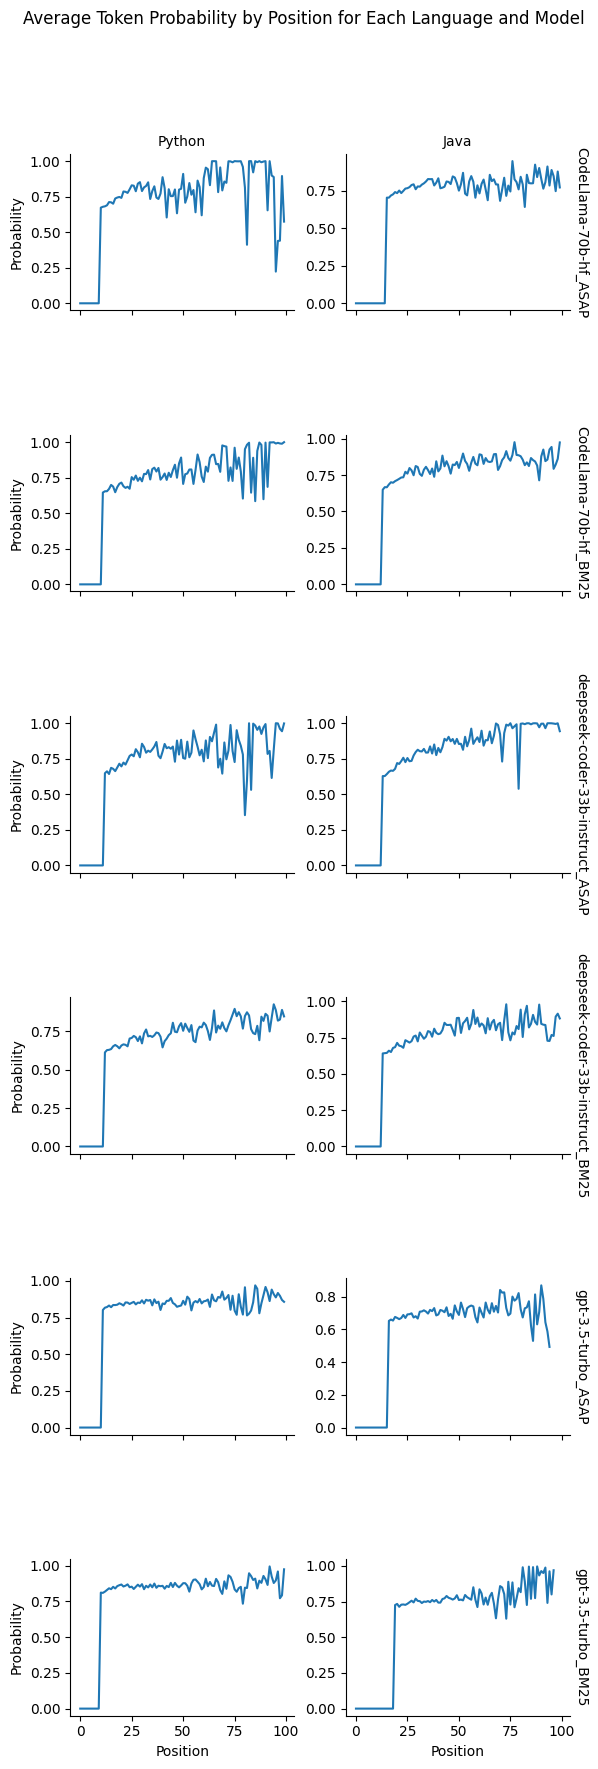

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for facet plot
facet_data = []
for language in prob_info:
    for model in prob_info[language]:
        avg_probs = prob_info[language][model]["avg_probs"]
        for position, prob in enumerate(avg_probs):
            facet_data.append({"Language": language, "Model": model, "Position": position, "Probability": prob})

facet_df = pd.DataFrame(facet_data)

# Create facet plot
g = sns.FacetGrid(facet_df, col="Language", row="Model", margin_titles=True, sharey=False)
g.map(sns.lineplot, "Position", "Probability")
g.set_axis_labels("Position", "Probability")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Average Token Probability by Position for Each Language and Model")
plt.show()

Python CodeLlama-70b-hf_ASAP


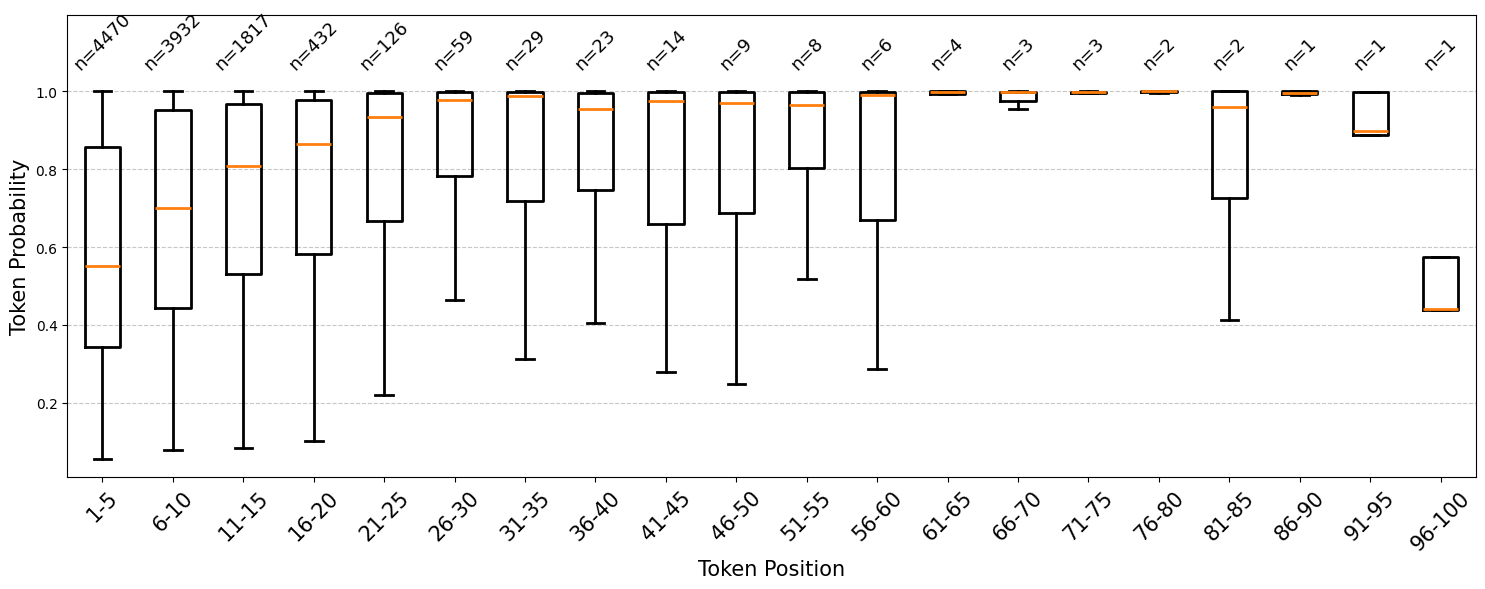

Python CodeLlama-70b-hf_BM25


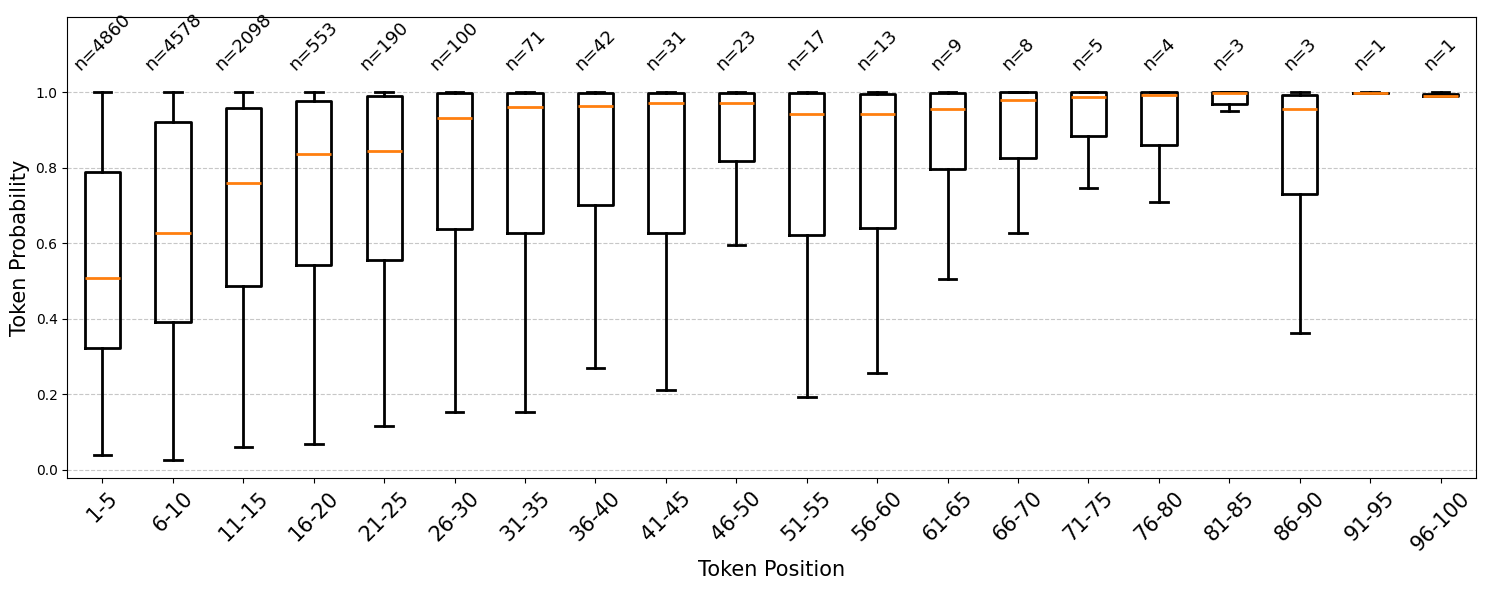

Python deepseek-coder-33b-instruct_ASAP


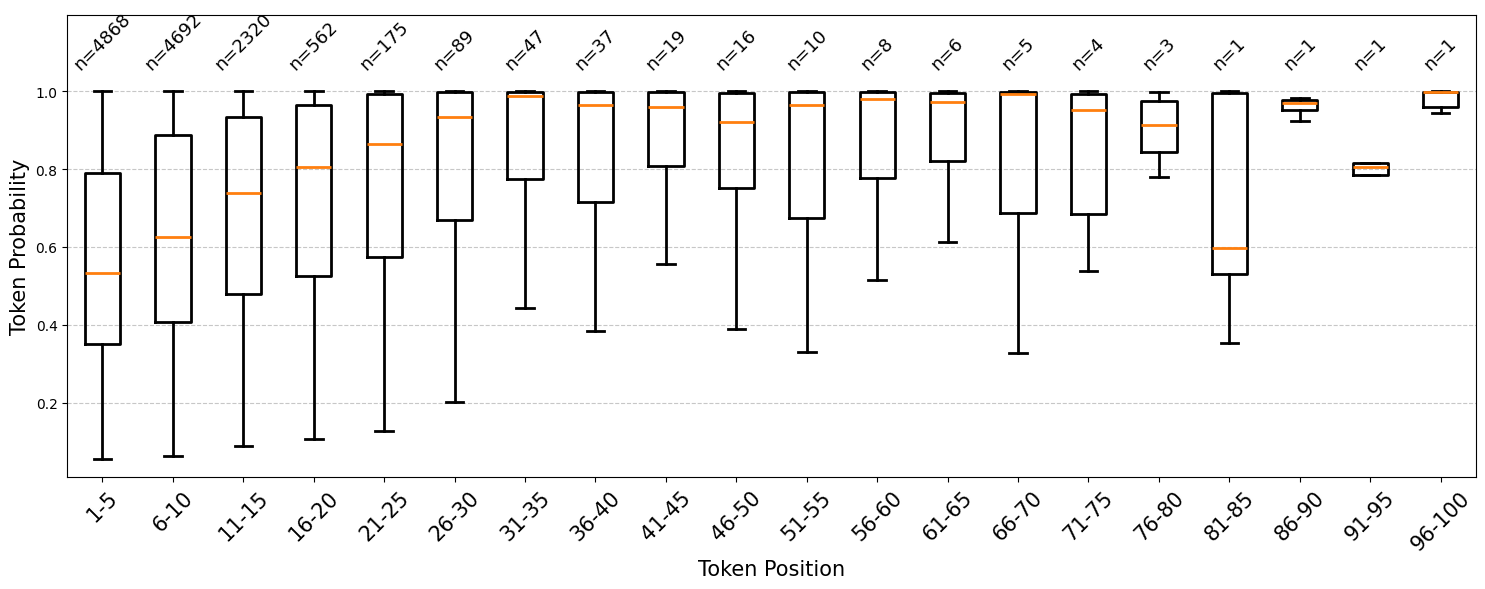

Python deepseek-coder-33b-instruct_BM25


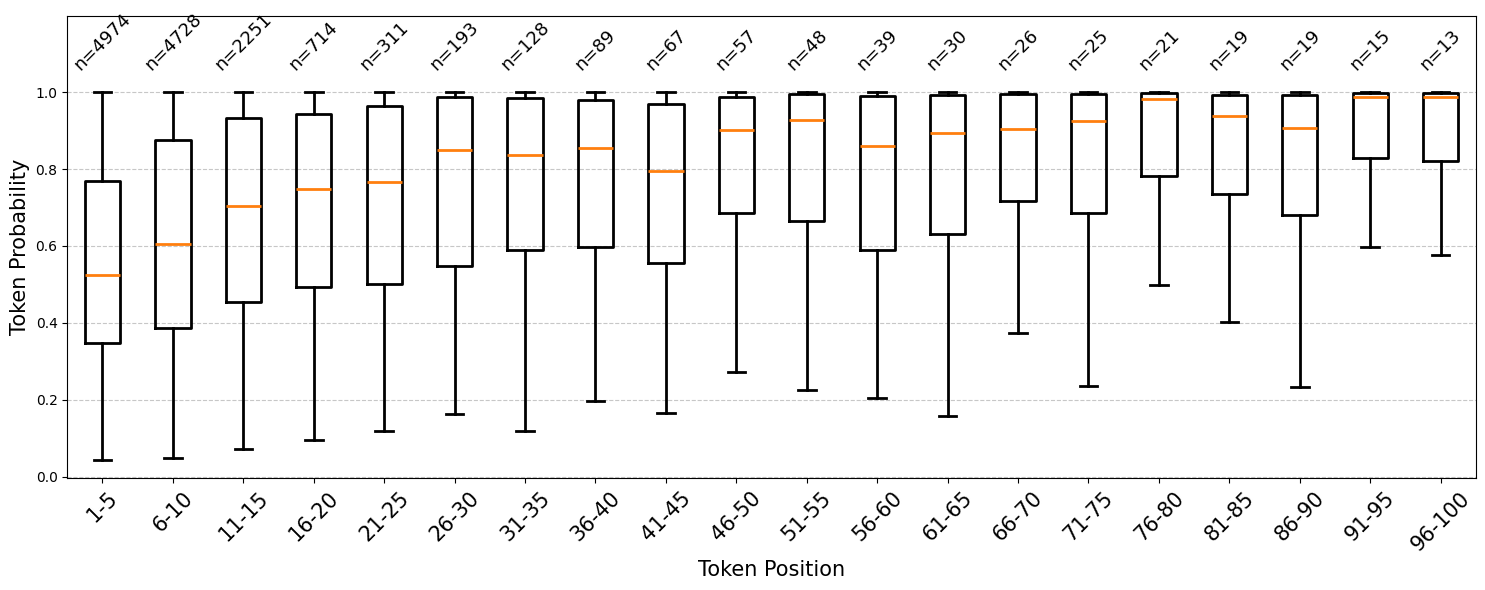

Python gpt-3.5-turbo_ASAP


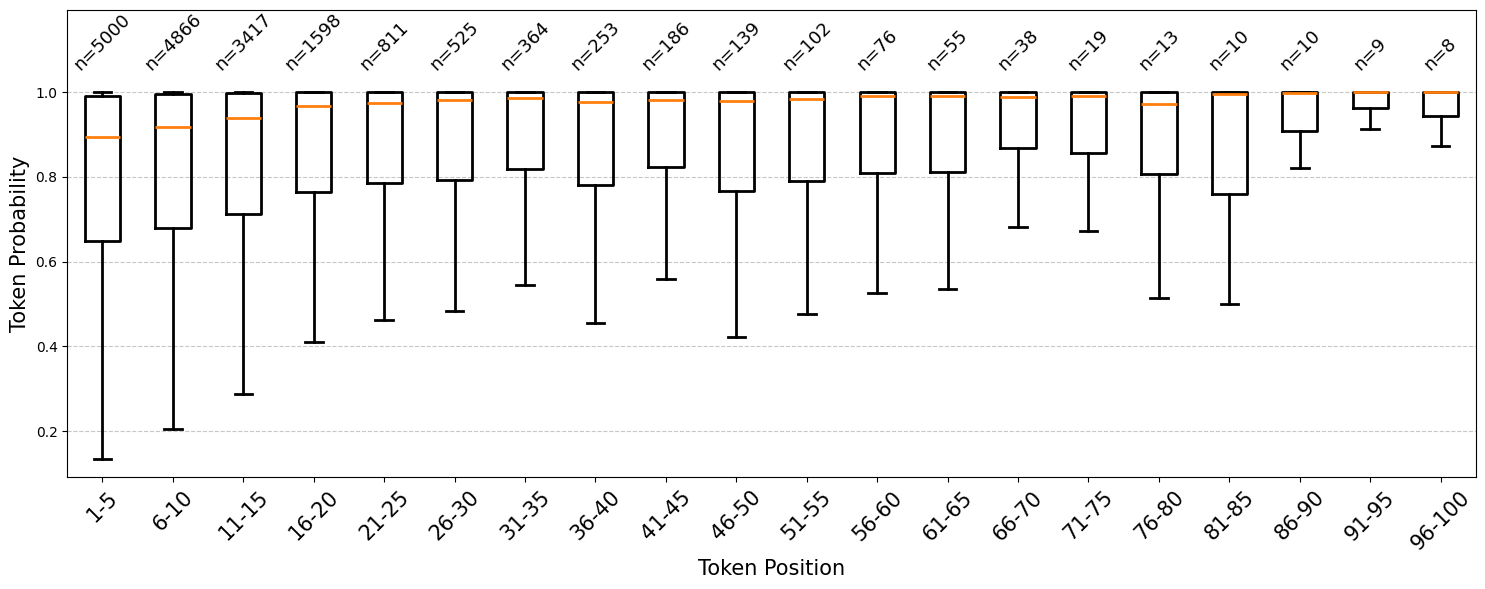

Python gpt-3.5-turbo_BM25


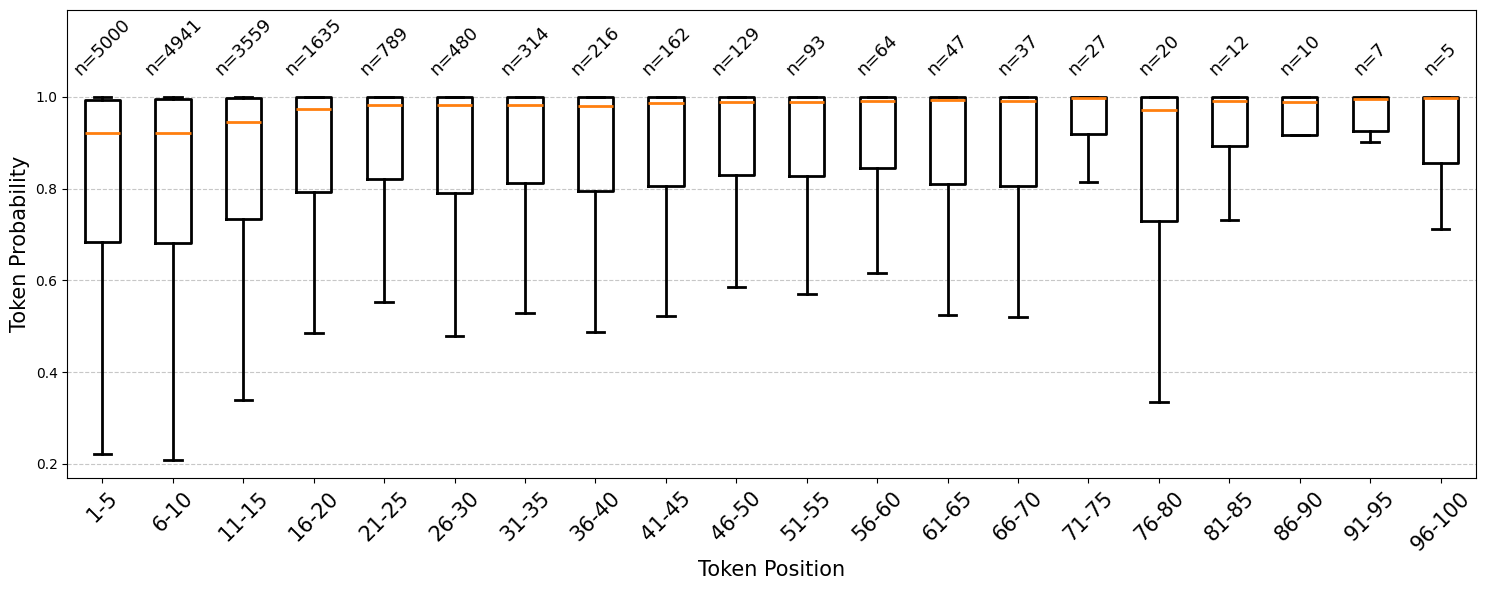

Java CodeLlama-70b-hf_ASAP


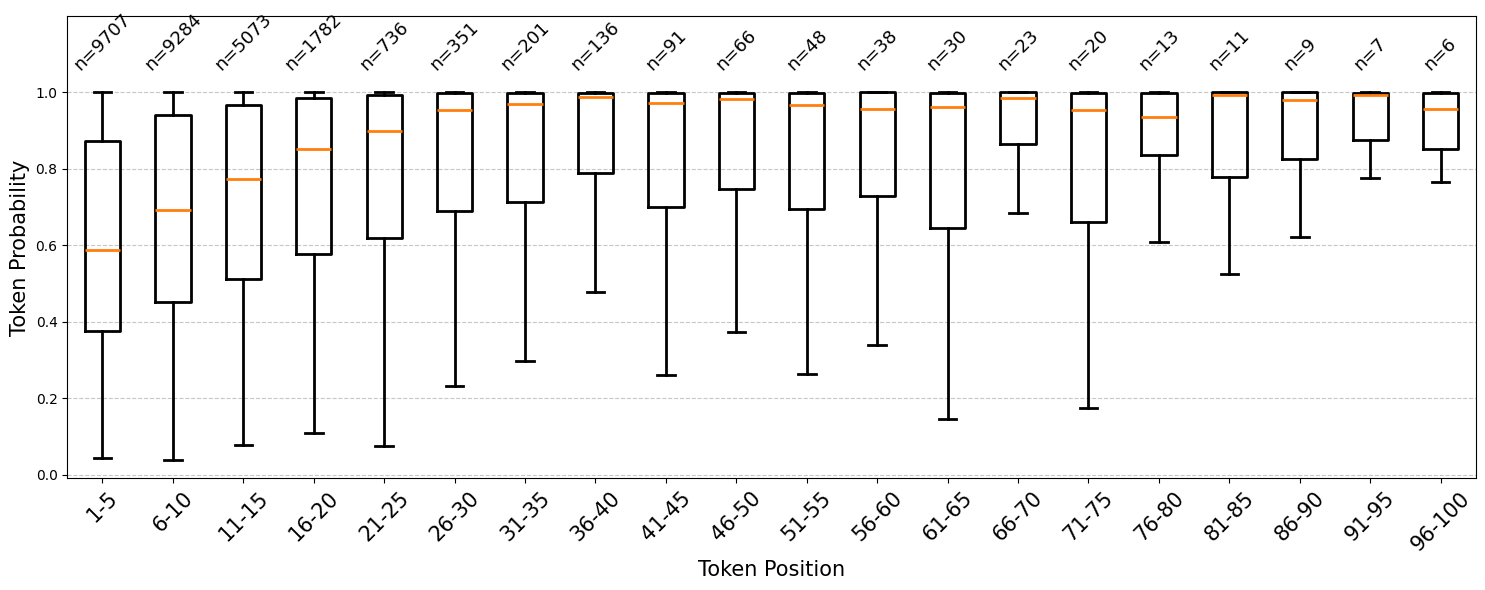

Java CodeLlama-70b-hf_BM25


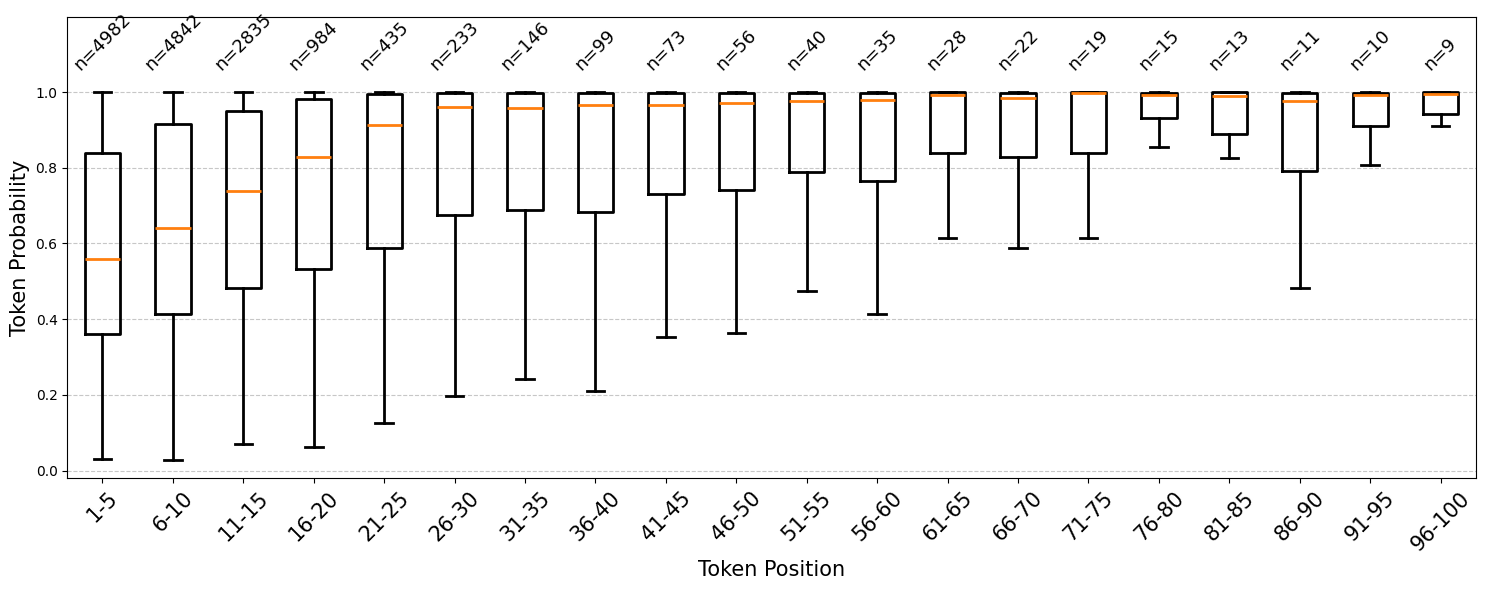

Java deepseek-coder-33b-instruct_ASAP


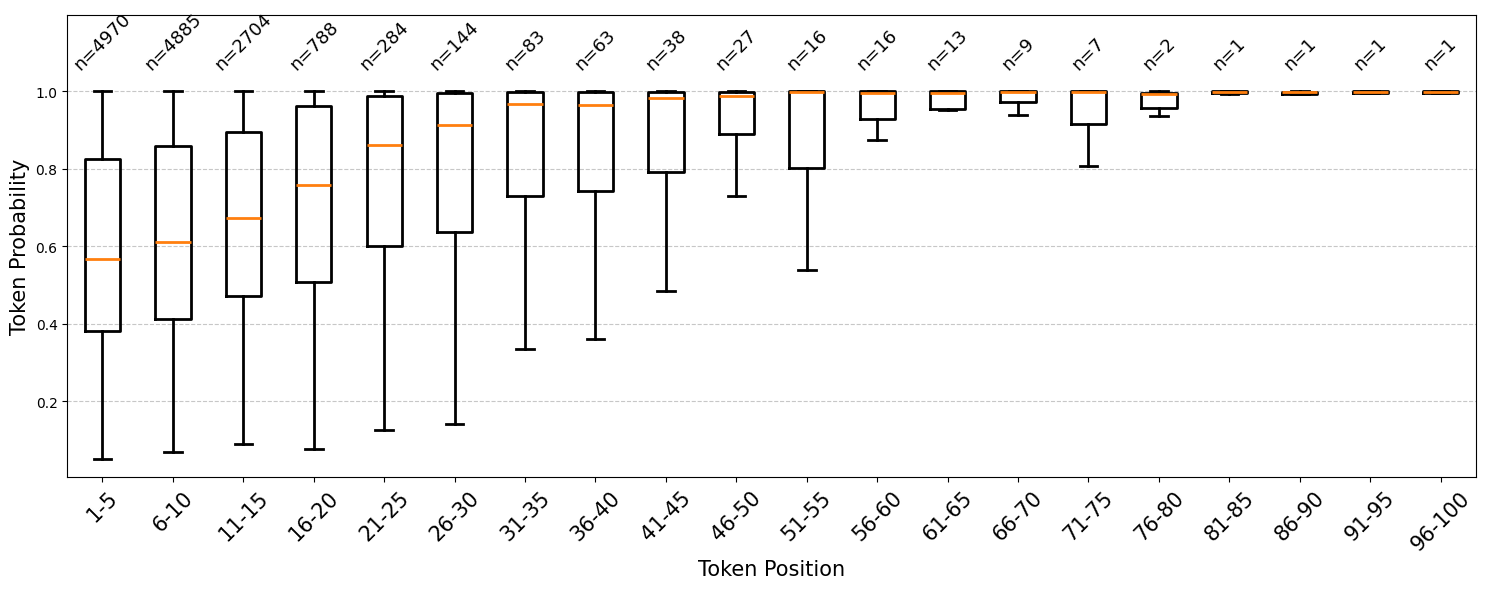

Java deepseek-coder-33b-instruct_BM25


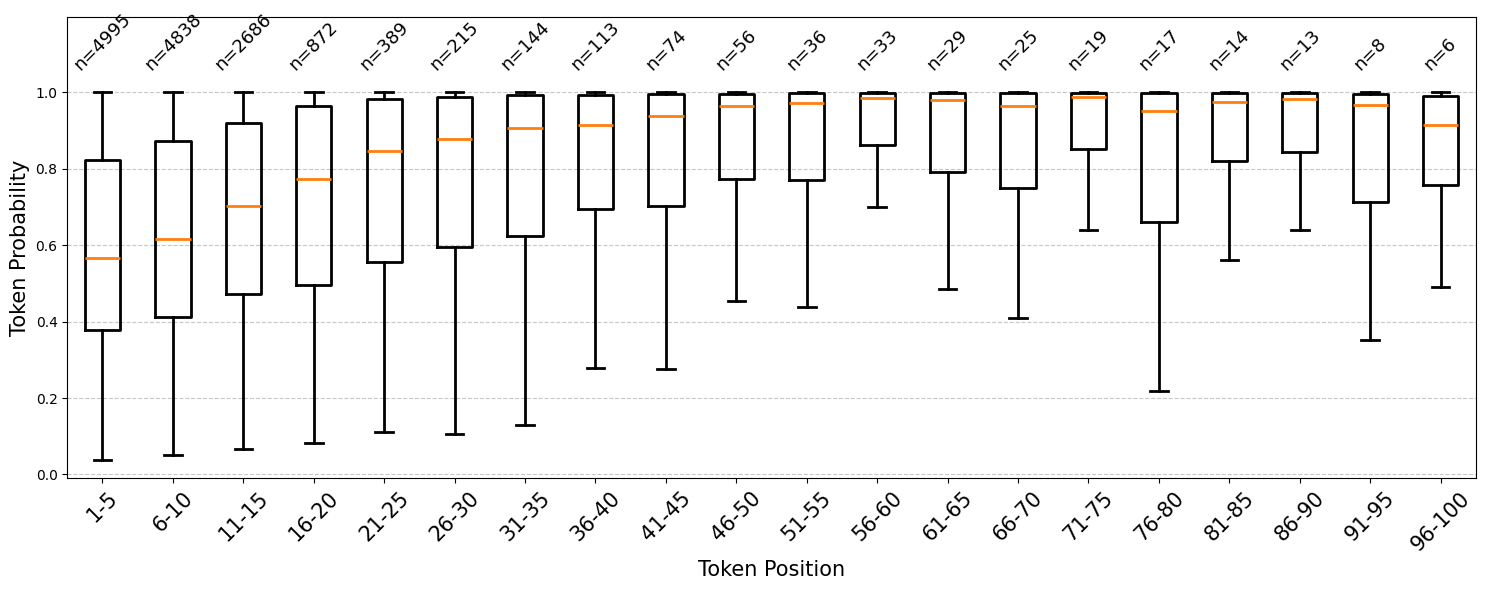

Java gpt-3.5-turbo_ASAP


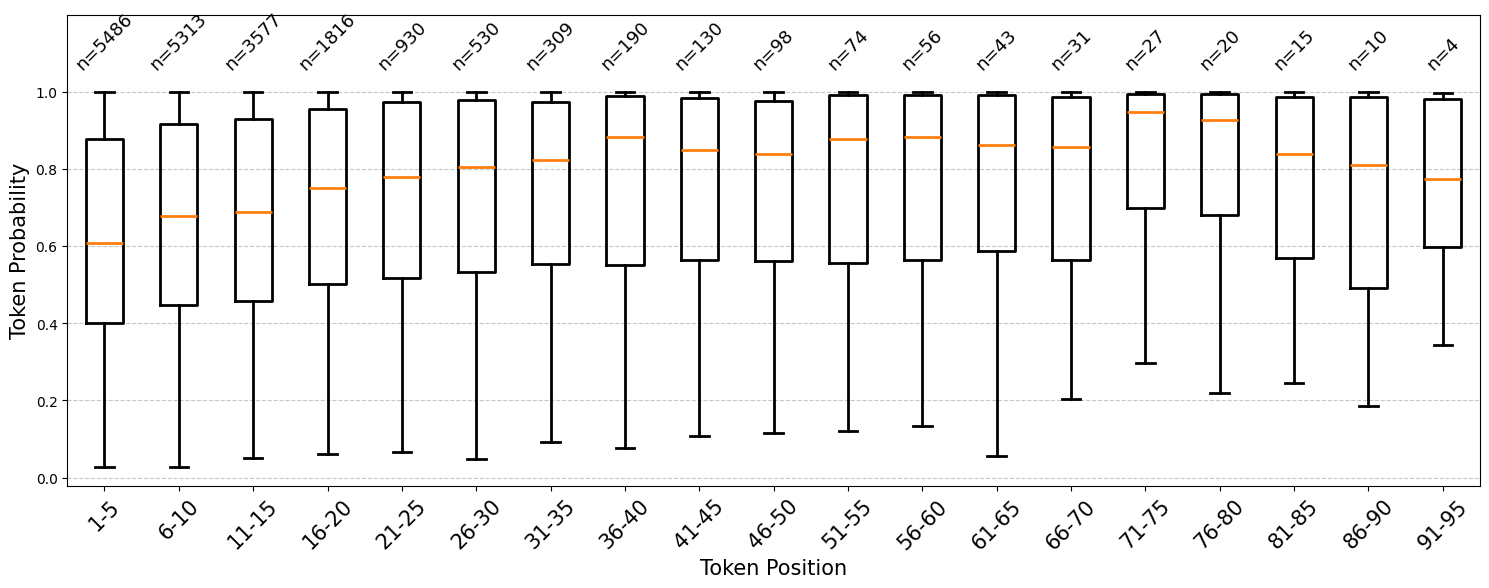

Java gpt-3.5-turbo_BM25


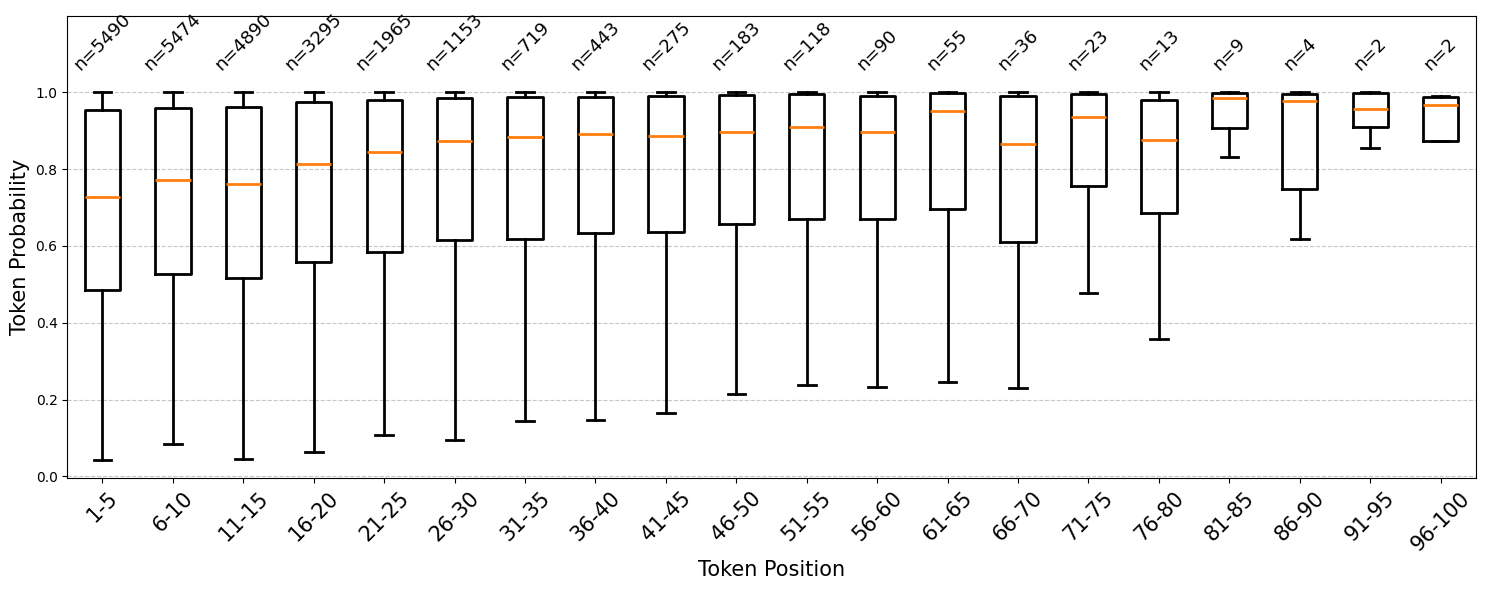

In [4]:
def plot_token_probabilities(probs_list_per_postion, sample_sizes, language, model, bucket_size):
    # Bucket the probabilities by 5 token positions
    bucketed_probs = [sum(probs_list_per_postion[i:i + bucket_size], []) for i in range(0, len(probs_list_per_postion), bucket_size)]
    # first position represents all summaries and bucker size range
    bucketed_sample_sizes = [sample_sizes[i] for i in range(0, len(sample_sizes), bucket_size)]

    # Create the box plot
    plt.figure(figsize=(15, 6))
    bp = plt.boxplot(bucketed_probs, showfliers=False)
    
    # Increase linewidth of box plot elements
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], linewidth=2)

    # Customize the plot
    plt.xlabel('Token Position', fontsize=15)
    plt.ylabel('Token Probability', fontsize=15)

    # Add x-axis labels for every bucket
    x_ticks = range(1, len(bucketed_probs) + 1)
    plt.xticks(x_ticks, [f"{bucket_size*(i-1)+1}-{bucket_size*i}" for i in x_ticks], fontsize=15, rotation=45)

    # Add a grid for better readability
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Add vertical space at the top of the plot
    plt.ylim(top=plt.ylim()[1] + 0.15)

    # red line at y= 0.5
    # plt.axhline(0.5, color='red', linestyle='--')

    # Label the sample size above each box plot
    for i, size in enumerate(bucketed_sample_sizes):
        plt.text(i + 1, plt.ylim()[1] - 0.15, f"n={size}", 
                 horizontalalignment='center', verticalalignment='bottom', size=13, rotation=45)

    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function
for language in prob_info:
    for model in prob_info[language]:
        print(language, model)
        plot_token_probabilities(prob_info[language][model]["probs_list_per_postion"], prob_info[language][model]["sample_sizes"], language, model, 5)


In [5]:
def geom_mean(probs):
    if len(probs) == 0:
        return 0
    elif len(probs) == 1:
        return probs[0]
    else:
        return np.prod(probs) ** (1 / len(probs))

for language in prob_info:
    for model in prob_info[language]:
        print(language, model, np.median(prob_info[language][model]["lengths"][:5000]), np.mean(prob_info[language][model]["lengths"][:5000]))
        print("Avg Geom Mean", np.mean([geom_mean(probs) for probs in prob_info[language][model]['probs_list_per_postion'][20:]]))
        print("Early confidences:", np.mean([np.mean(probs) for probs in prob_info[language][model]['probs_list_per_postion'][1:6]]))
        # plot_token_probabilities(prob_info[language][model]["probs_list_per_postion"], prob_info[language][model]["sample_sizes"], language, model, 5)


Python CodeLlama-70b-hf_ASAP 10.0 10.224384787472037
Avg Geom Mean 0.8273219051128315
Early confidences: 0.6492851747227557
Python CodeLlama-70b-hf_BM25 10.0 11.003292181069959
Avg Geom Mean 0.8230245134472662
Early confidences: 0.6031011204751626
Python deepseek-coder-33b-instruct_ASAP 10.0 11.244453574363188
Avg Geom Mean 0.8231460113040555
Early confidences: 0.6158376805000488
Python deepseek-coder-33b-instruct_BM25 10.0 11.862082830719743
Avg Geom Mean 0.7680429395505232
Early confidences: 0.6011673551830448
Python gpt-3.5-turbo_ASAP 13.0 15.5444
Avg Geom Mean 0.8607222358779005
Early confidences: 0.8304687617503534
Python gpt-3.5-turbo_BM25 13.0 15.5654
Avg Geom Mean 0.868674883235135
Early confidences: 0.8393235594365708
Java CodeLlama-70b-hf_ASAP 11.0 12.3034
Avg Geom Mean 0.7972872368380477
Early confidences: 0.6669952910726762
Java CodeLlama-70b-hf_BM25 11.0 12.95463669209153
Avg Geom Mean 0.8296816204348991
Early confidences: 0.6413764049829067
Java deepseek-coder-33b-instruc

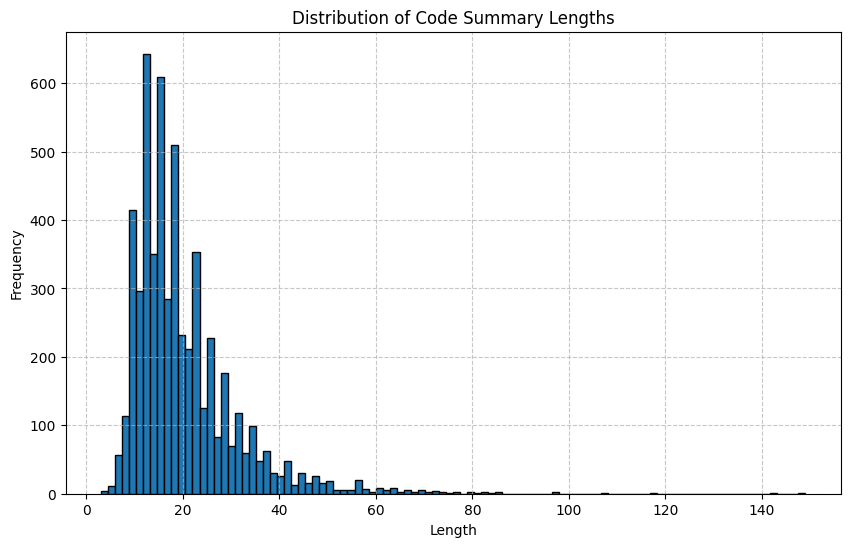

In [6]:
# Generate a histogram of lengths
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=100, edgecolor='black')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Code Summary Lengths')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


In [12]:
raw_calib = "results/early_token_cutoffs/Java_CodeLlama-70b-hf_BM25_position_vs_raw_calib.csv"
raw_calib_df = pd.read_csv(raw_calib)
scaled_calib = "results/early_token_cutoffs/Java_CodeLlama-70b-hf_BM25_position_vs_scaled_calib_by_all.csv"
scaled_calib_df = pd.read_csv(scaled_calib)

In [14]:
languages = ["Python", "Java"]
models = ["CodeLlama-70b-hf", "gpt-3.5-turbo", "deepseek-coder-33b-instruct"]
methods = ["ASAP", "BM25"]

dfs = {}
for language in languages:
    dfs[language] = {}
    for model in models:
        dfs[language][model] = {}
        for method in methods:
            raw_calib = f"results/early_token_cutoffs/{language}_{model}_{method}_BERT Score-R_position_vs_raw_calib_geometric_mean.csv"
            try:
                raw_calib_df = pd.read_csv(raw_calib)
            except Exception as e:
                print(f"Error reading {raw_calib}: {e}")
            scaled_calib = f"results/early_token_cutoffs/{language}_{model}_{method}_BERT Score-R_optimal_position_vs_scaled_calib_by_all_geometric_mean.csv"
            try:
                scaled_calib_df = pd.read_csv(scaled_calib)
            except Exception as e:
                print(f"Error reading {scaled_calib}: {e}")
            dfs[language][model][method] = {"raw_calib": raw_calib_df, "scaled_calib": scaled_calib_df}

Error reading results/early_token_cutoffs/Python_CodeLlama-70b-hf_ASAP_BERT Score-R_position_vs_raw_calib_geometric_mean.csv: No columns to parse from file
Error reading results/early_token_cutoffs/Python_CodeLlama-70b-hf_BM25_BERT Score-R_position_vs_raw_calib_geometric_mean.csv: No columns to parse from file
Error reading results/early_token_cutoffs/Python_gpt-3.5-turbo_ASAP_BERT Score-R_position_vs_raw_calib_geometric_mean.csv: No columns to parse from file
Error reading results/early_token_cutoffs/Python_gpt-3.5-turbo_BM25_BERT Score-R_position_vs_raw_calib_geometric_mean.csv: No columns to parse from file
Error reading results/early_token_cutoffs/Python_deepseek-coder-33b-instruct_ASAP_BERT Score-R_position_vs_raw_calib_geometric_mean.csv: No columns to parse from file
Error reading results/early_token_cutoffs/Python_deepseek-coder-33b-instruct_BM25_BERT Score-R_position_vs_raw_calib_geometric_mean.csv: No columns to parse from file
Error reading results/early_token_cutoffs/Java_C

In [15]:
print(dfs["Java"]["CodeLlama-70b-hf"]["BM25"]['scaled_calib']['Skill score'])

0     0.067688
1     0.086553
2     0.097950
3     0.108621
4     0.116647
        ...   
95    0.104125
96    0.104112
97    0.104108
98    0.104122
99    0.104108
Name: Skill score, Length: 100, dtype: float64


Python CodeLlama-70b-hf ASAP


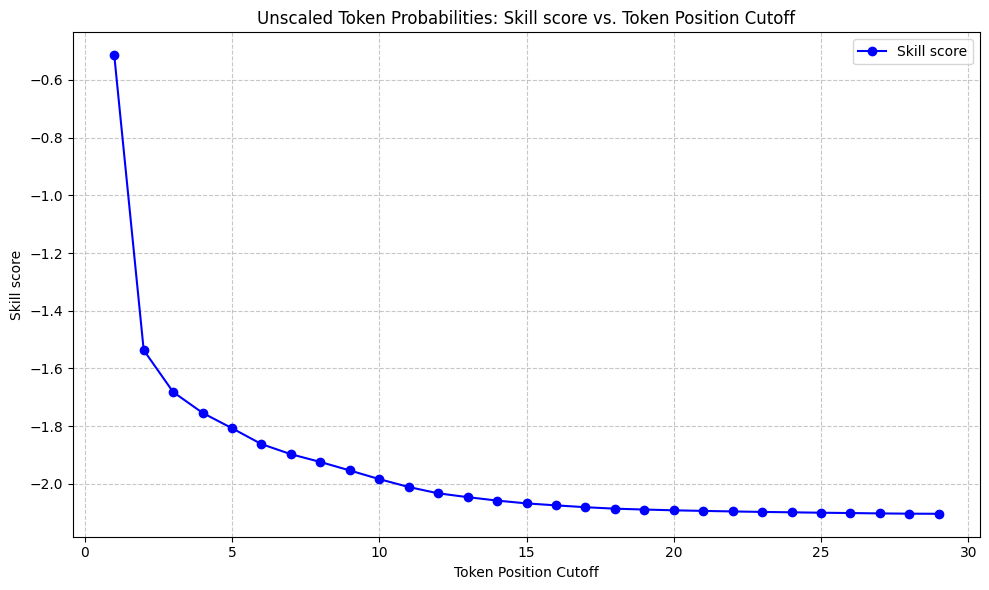

Python CodeLlama-70b-hf BM25


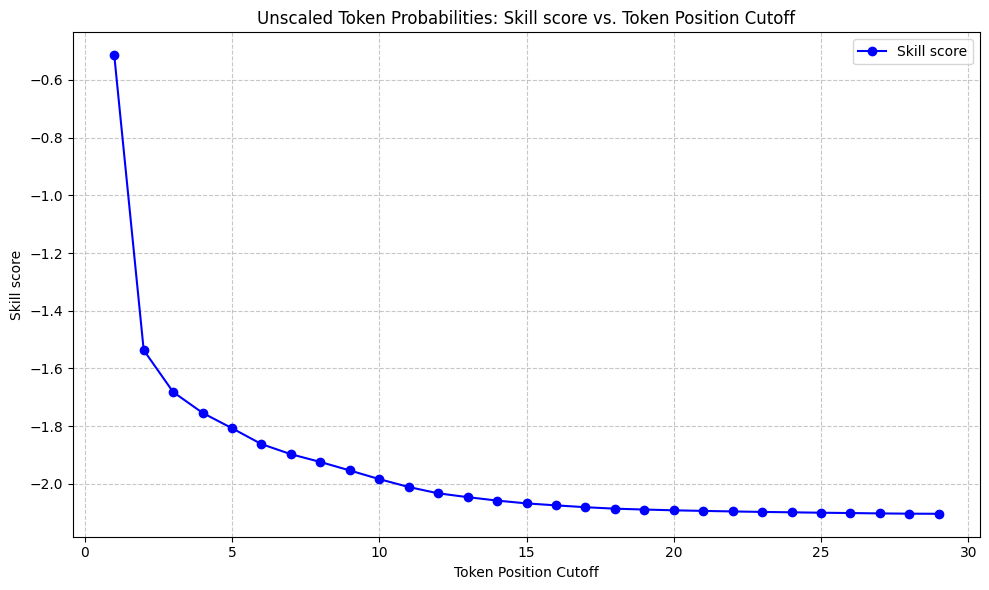

Python gpt-3.5-turbo ASAP


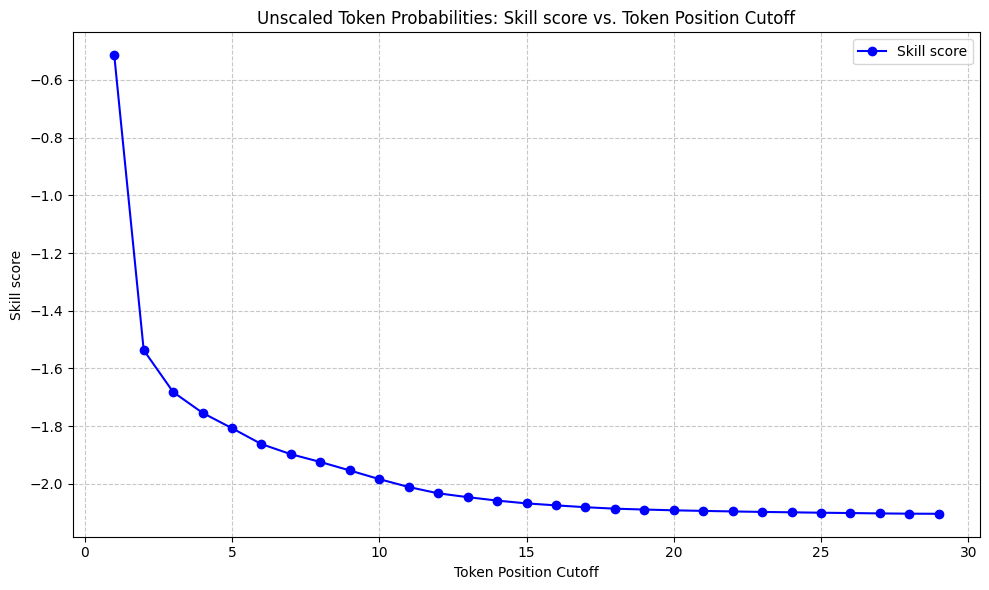

Python gpt-3.5-turbo BM25


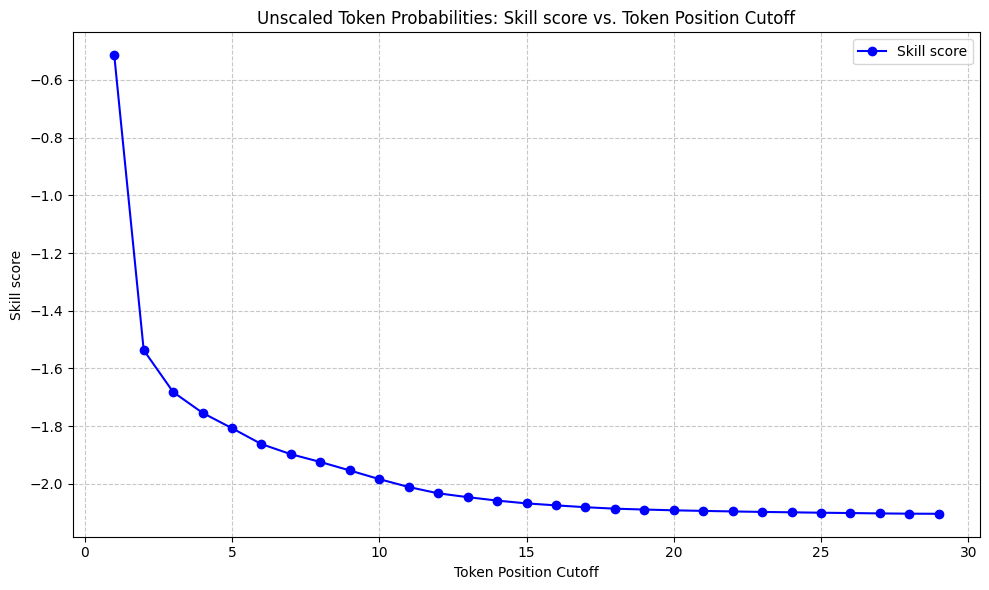

Python deepseek-coder-33b-instruct ASAP


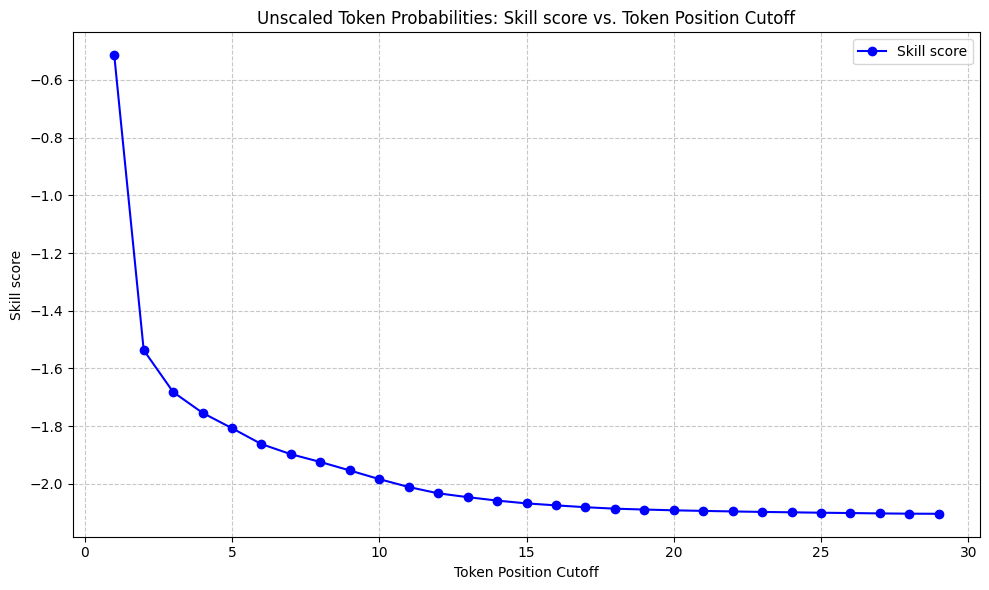

Python deepseek-coder-33b-instruct BM25


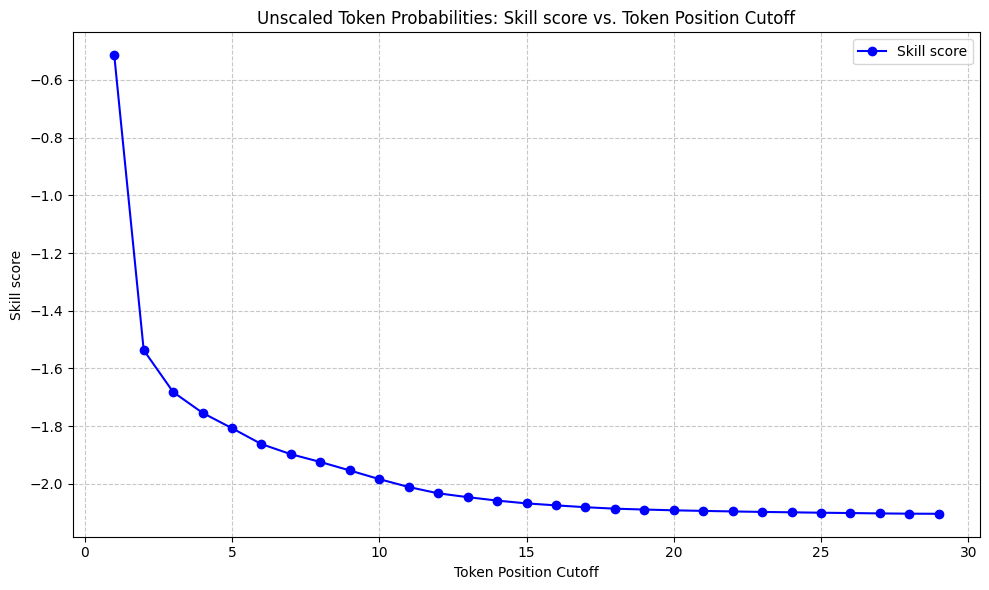

Java CodeLlama-70b-hf ASAP


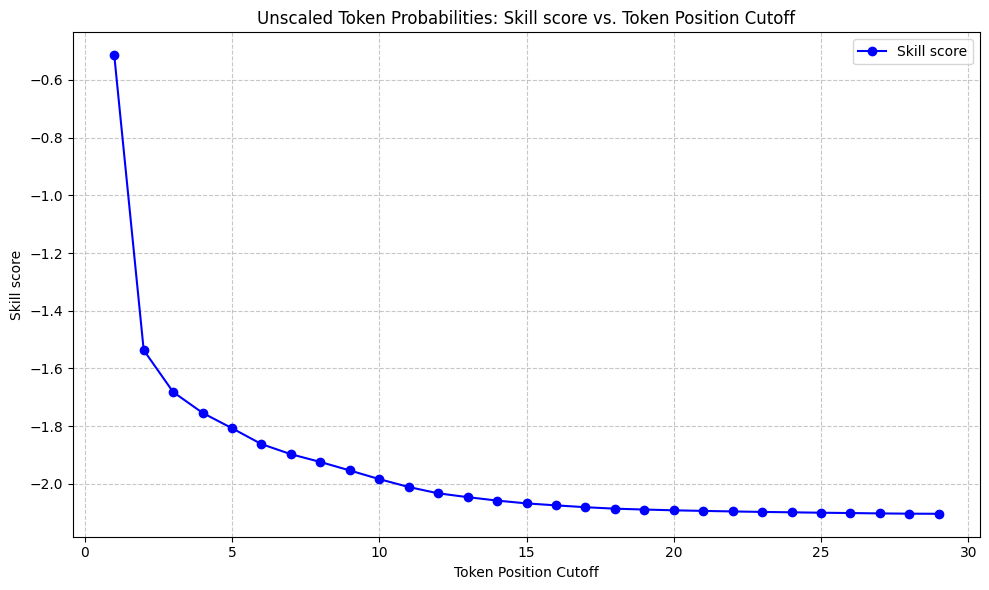

Java CodeLlama-70b-hf BM25


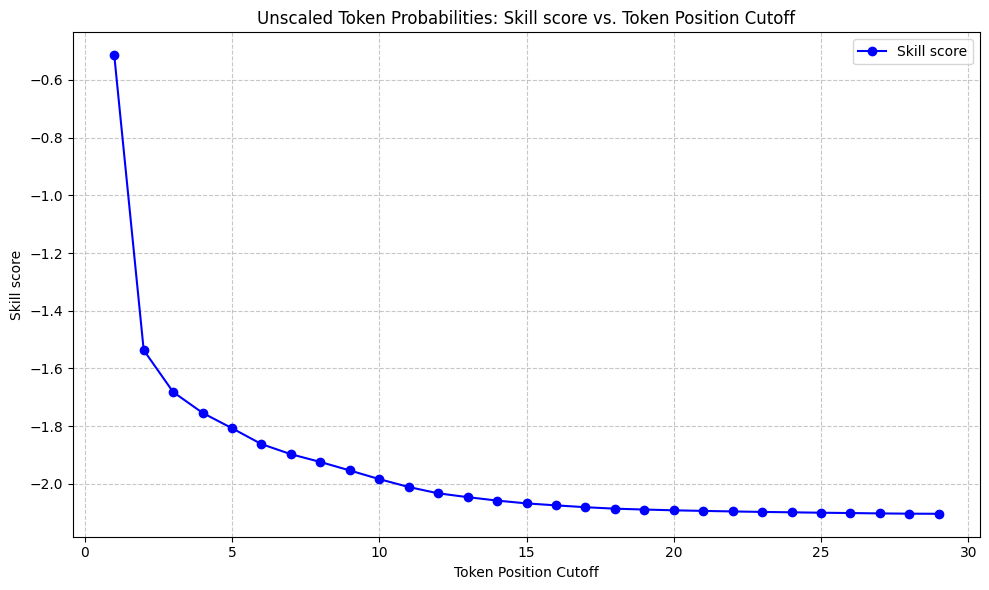

Java gpt-3.5-turbo ASAP


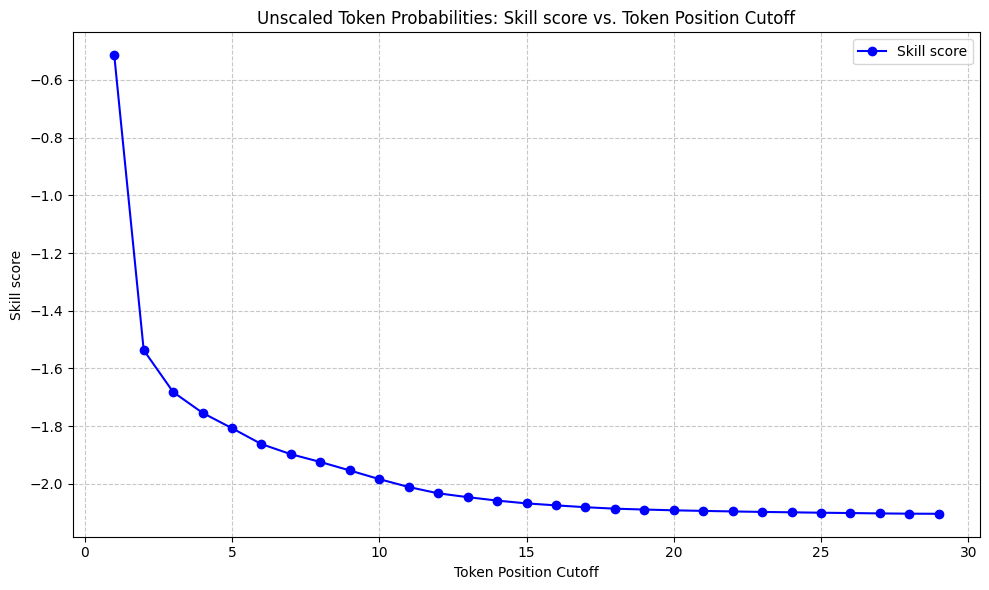

Java gpt-3.5-turbo BM25


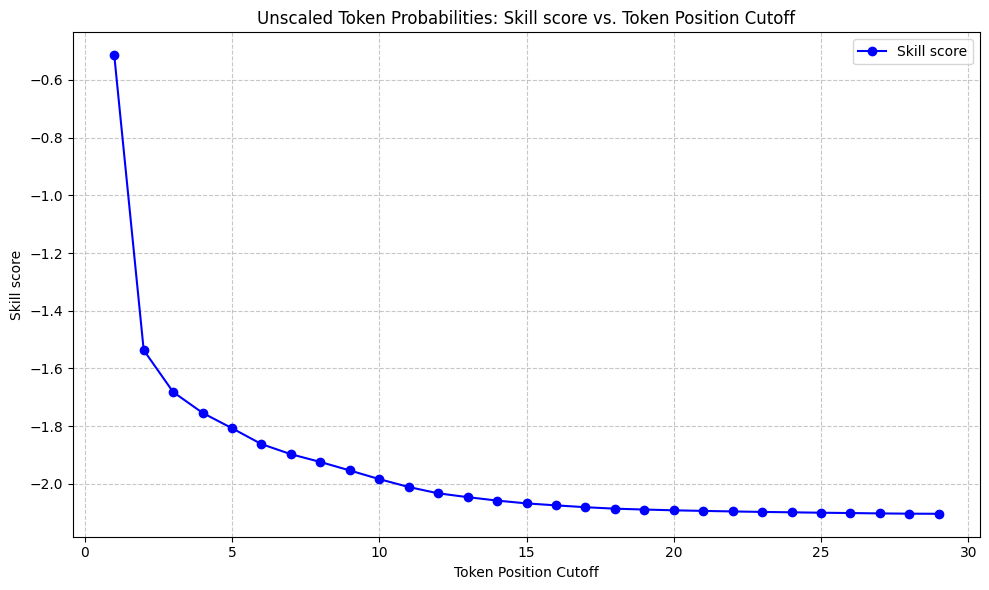

Java deepseek-coder-33b-instruct ASAP


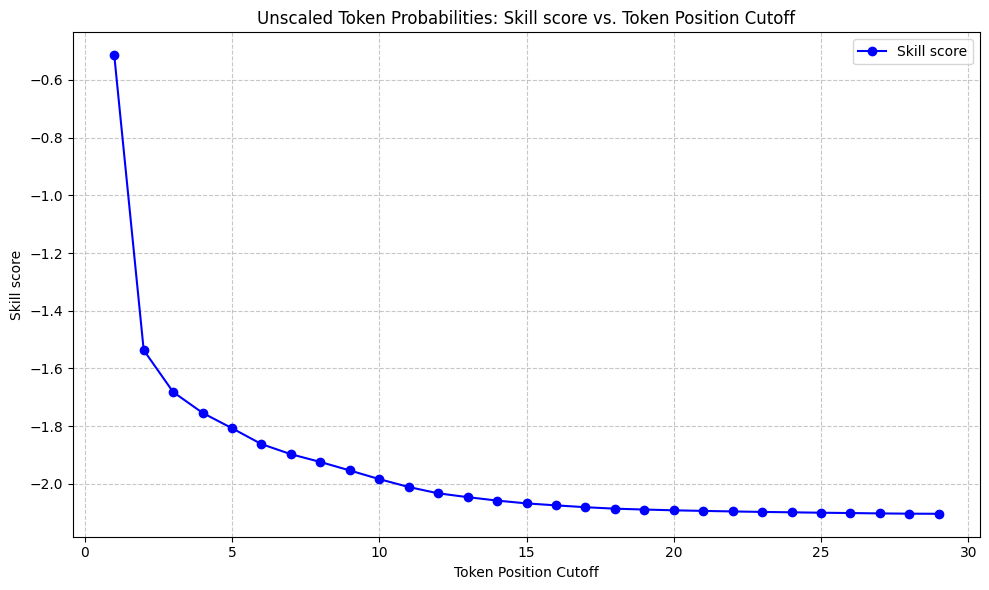

Java deepseek-coder-33b-instruct BM25


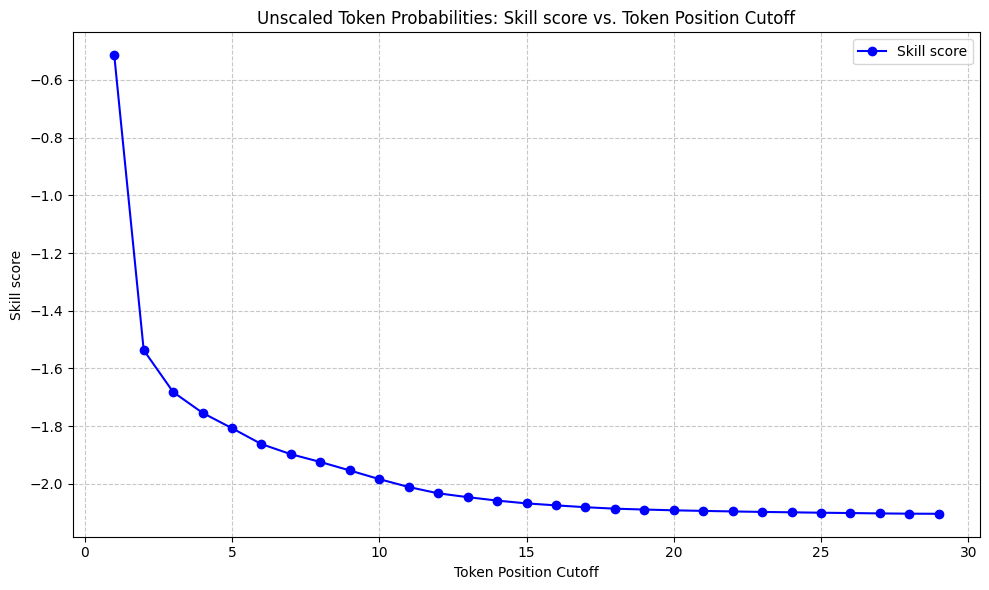

In [16]:
for language in dfs:
    for model in dfs[language]:
        for method in dfs[language][model]:
            print(language, model, method)
            plt.figure(figsize=(10, 6))
            all_summary_lengths_raw_df = dfs[language][model][method]["raw_calib"][dfs[language][model][method]["raw_calib"]["length_range"] == "(0, 100)"]
            plt.plot(all_summary_lengths_raw_df['token_position'], all_summary_lengths_raw_df['Skill score'], marker='o', linestyle='-', color='b', label='Skill score')
            plt.xlabel('Token Position Cutoff')
            plt.ylabel('Skill score')
            plt.title('Unscaled Token Probabilities: Skill score vs. Token Position Cutoff')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend()
            plt.tight_layout()
            plt.show()

Python CodeLlama-70b-hf ASAP


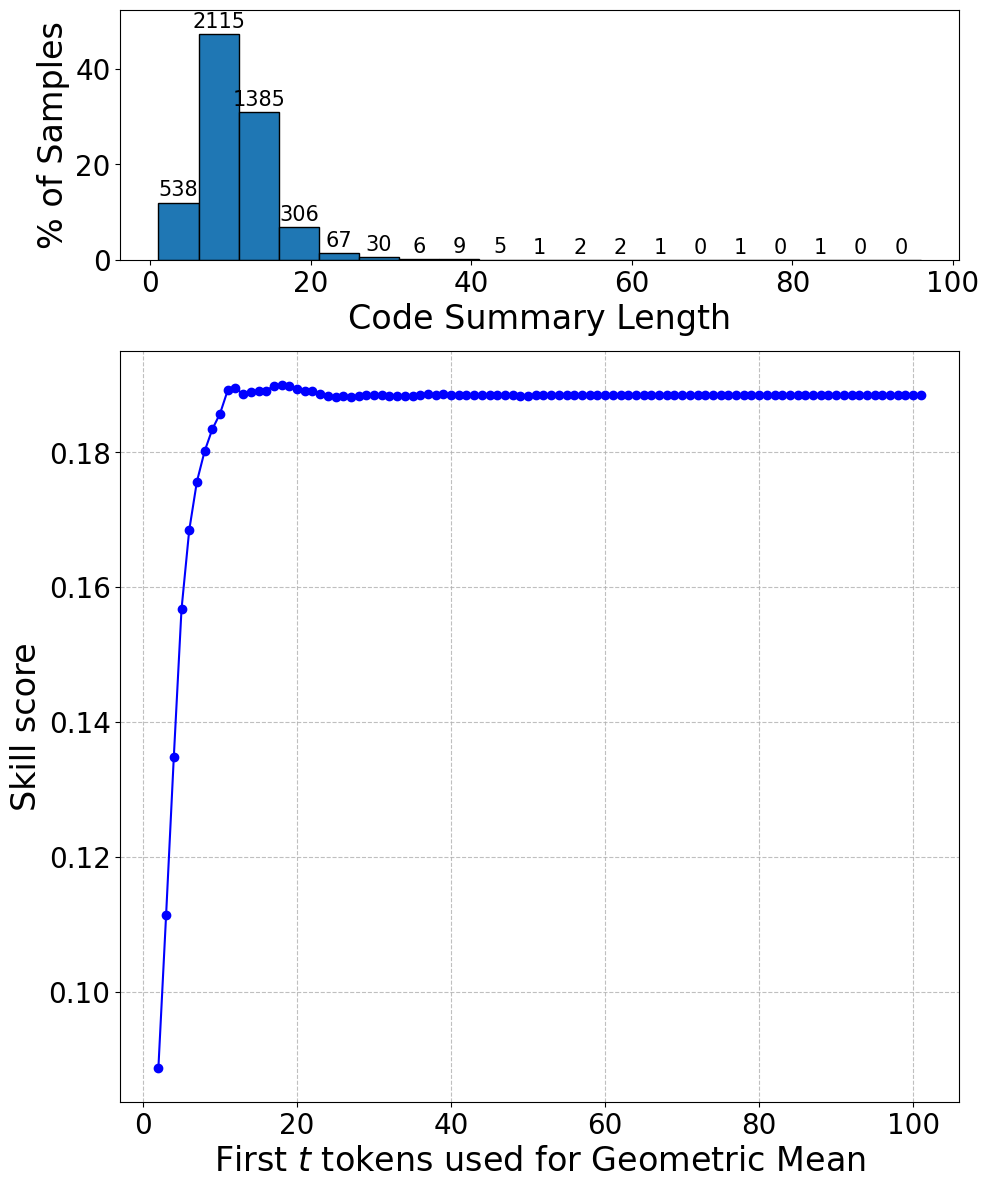

Python CodeLlama-70b-hf BM25


<Figure size 640x480 with 0 Axes>

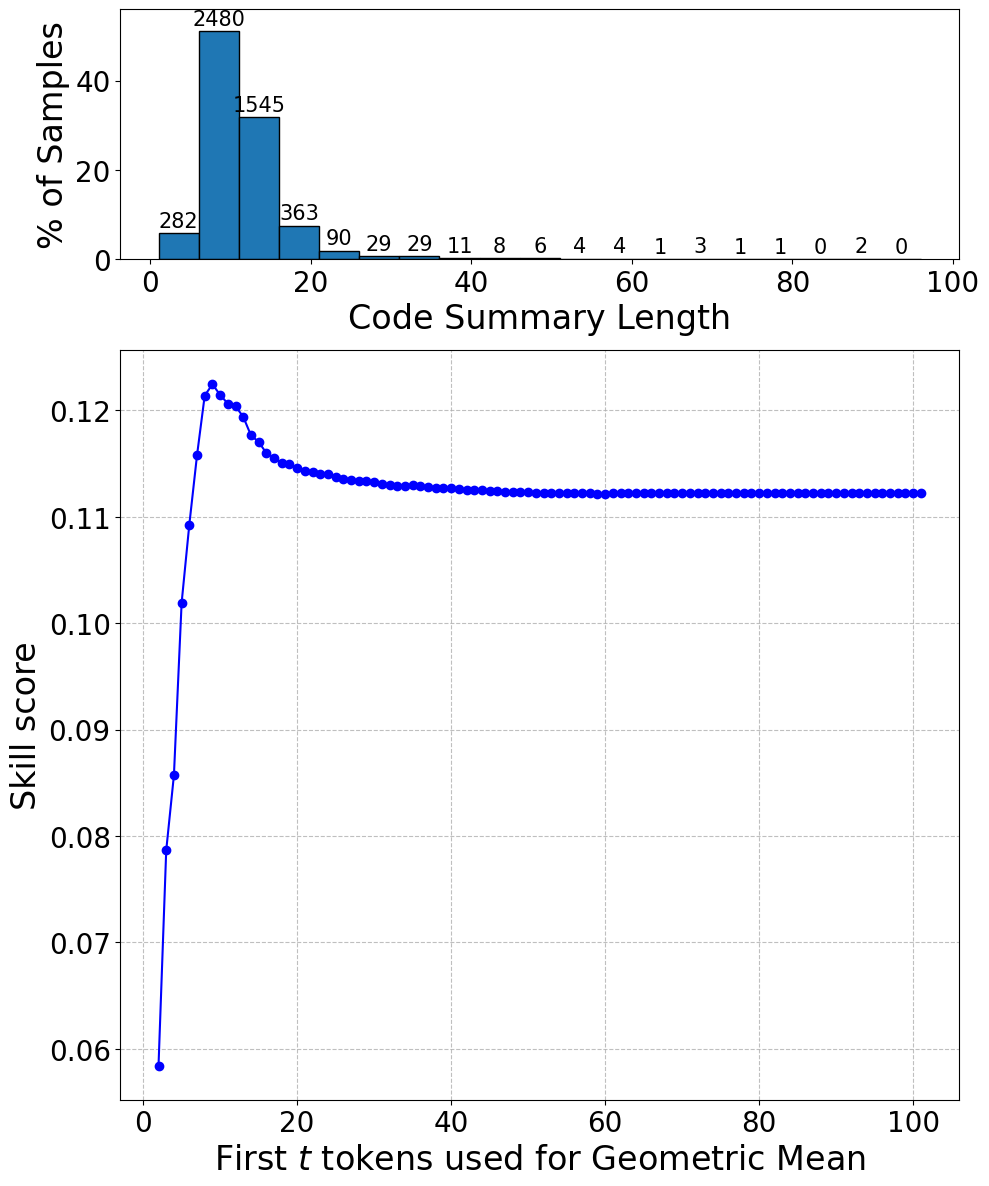

Python gpt-3.5-turbo ASAP


<Figure size 640x480 with 0 Axes>

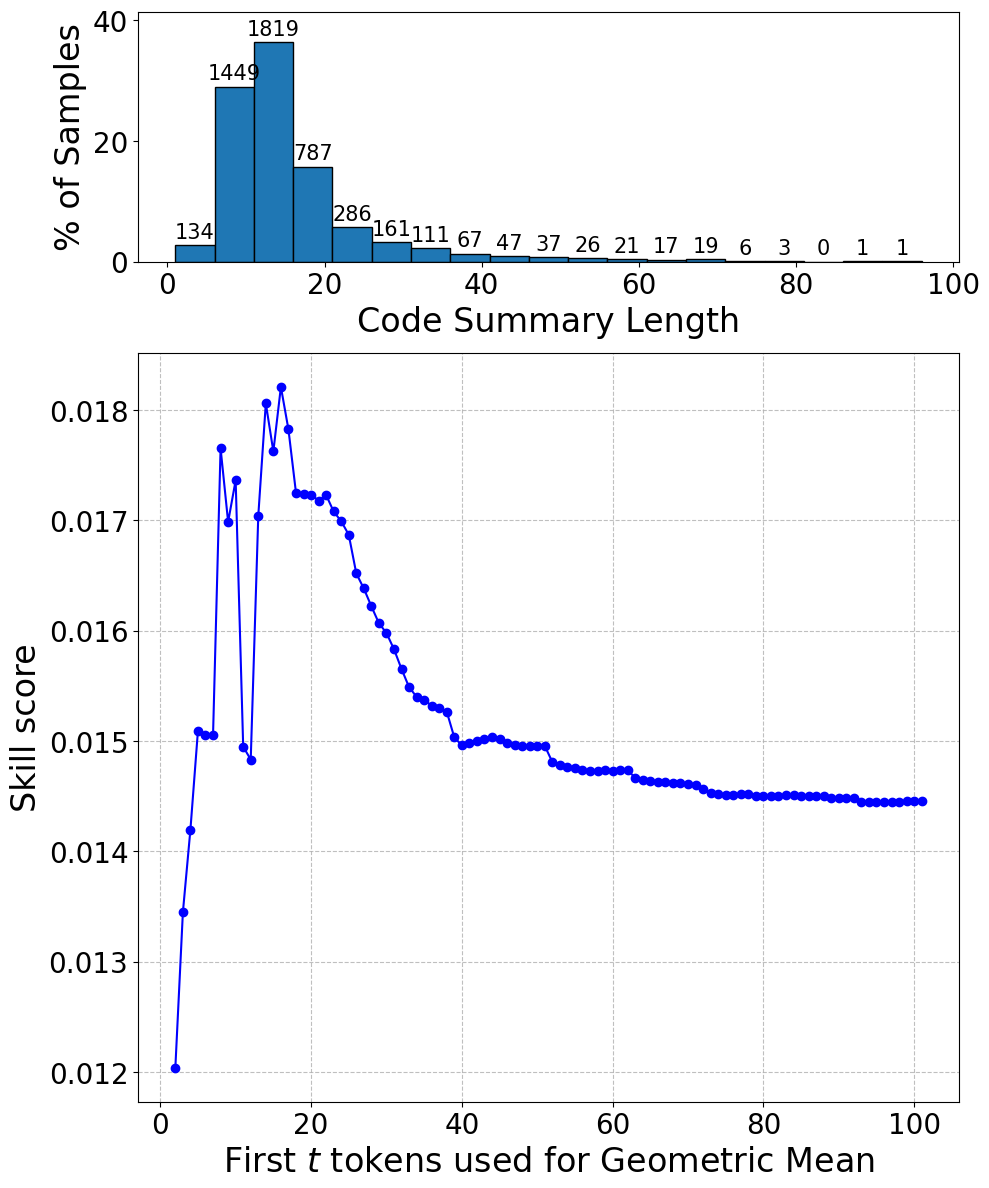

Python gpt-3.5-turbo BM25


<Figure size 640x480 with 0 Axes>

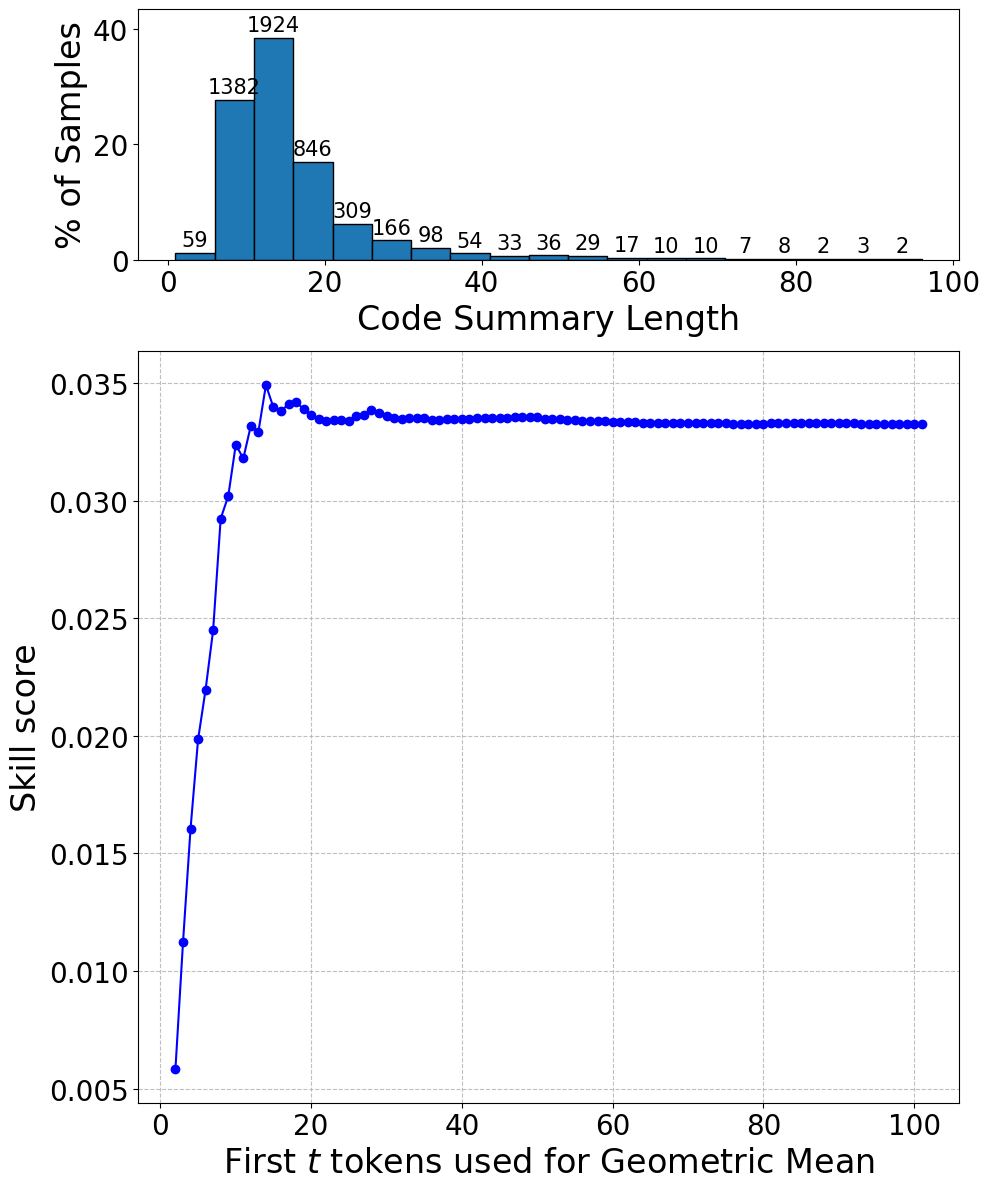

Python deepseek-coder-33b-instruct ASAP


<Figure size 640x480 with 0 Axes>

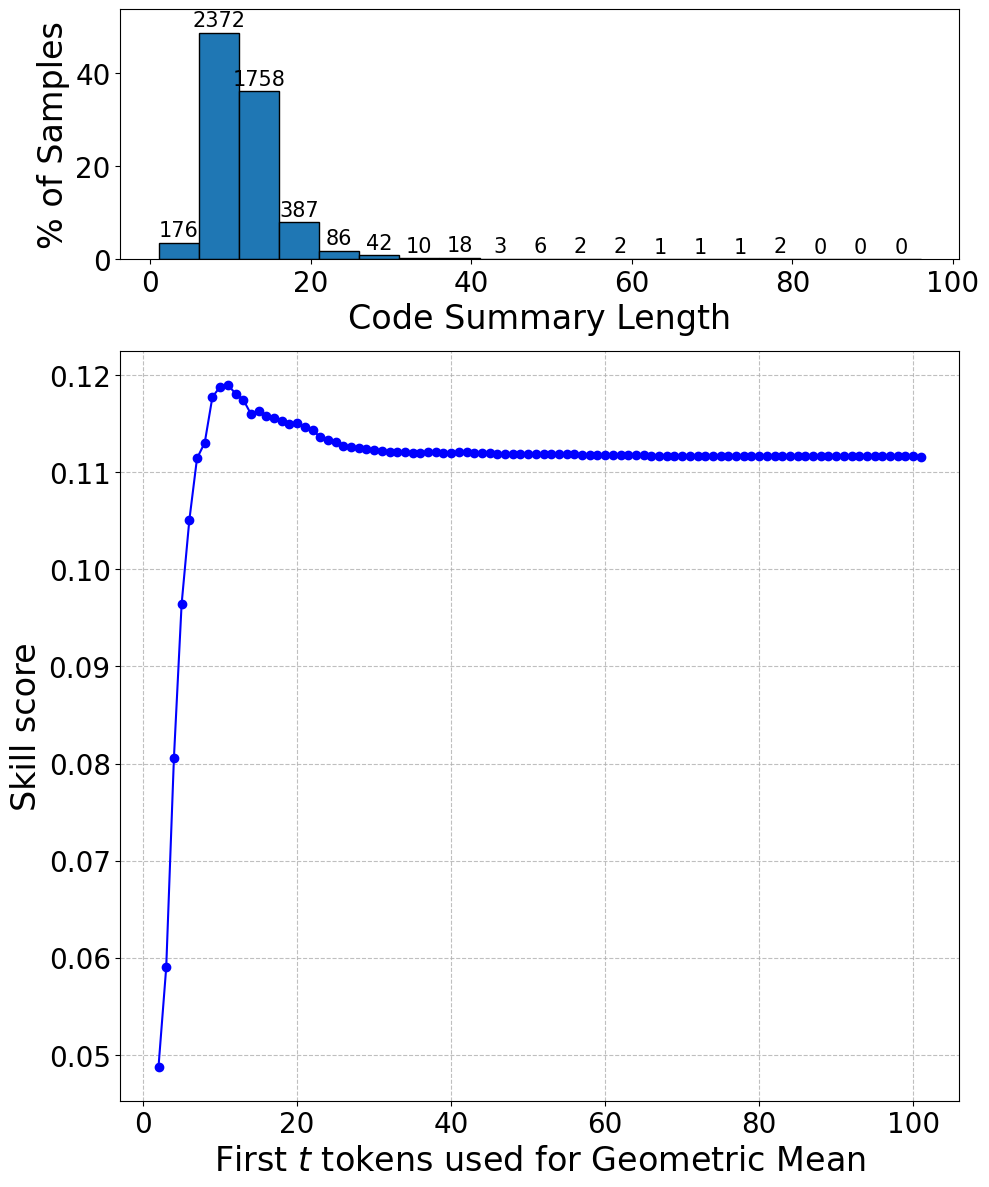

Python deepseek-coder-33b-instruct BM25


<Figure size 640x480 with 0 Axes>

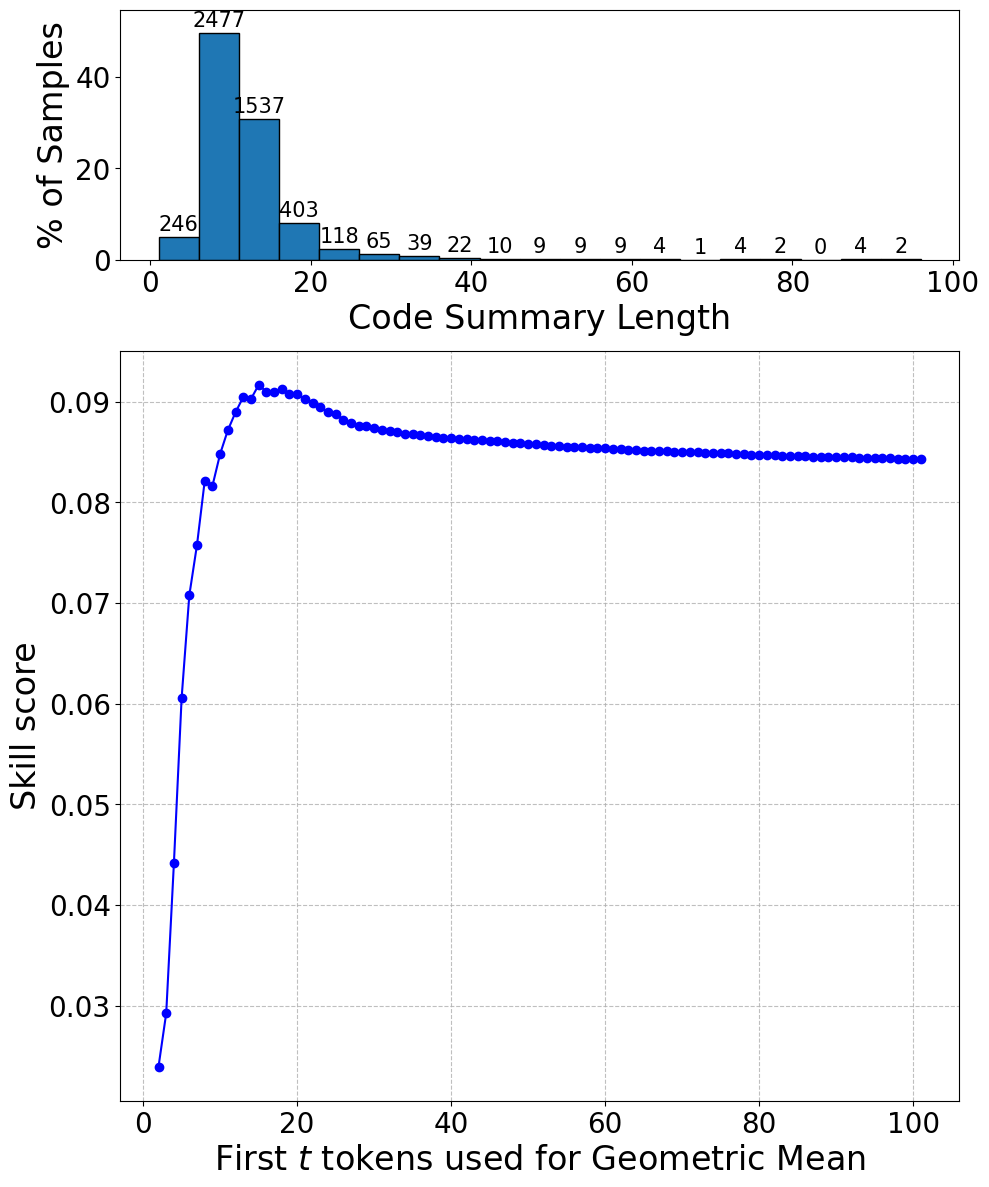

Java CodeLlama-70b-hf ASAP


<Figure size 640x480 with 0 Axes>

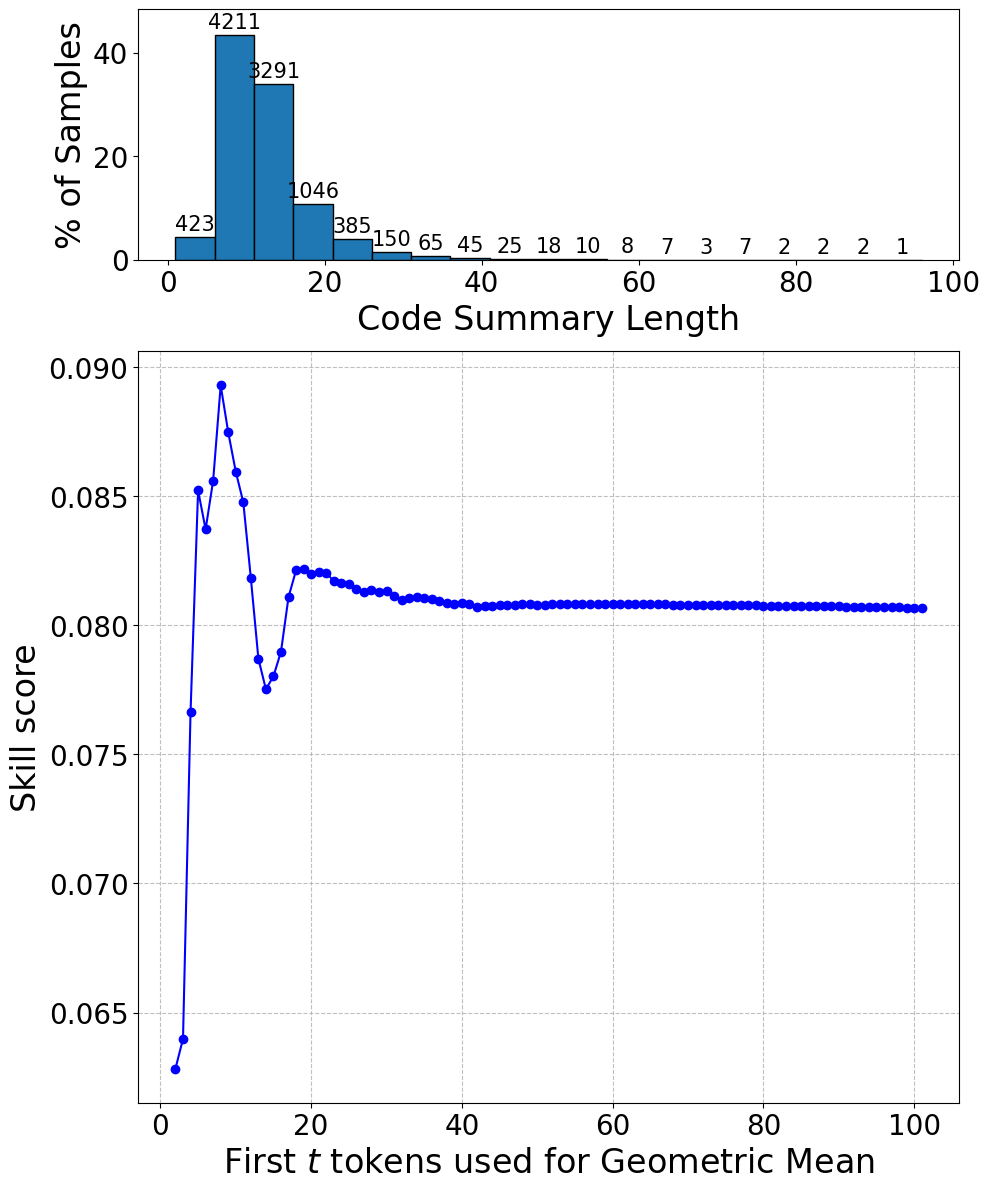

Java CodeLlama-70b-hf BM25


<Figure size 640x480 with 0 Axes>

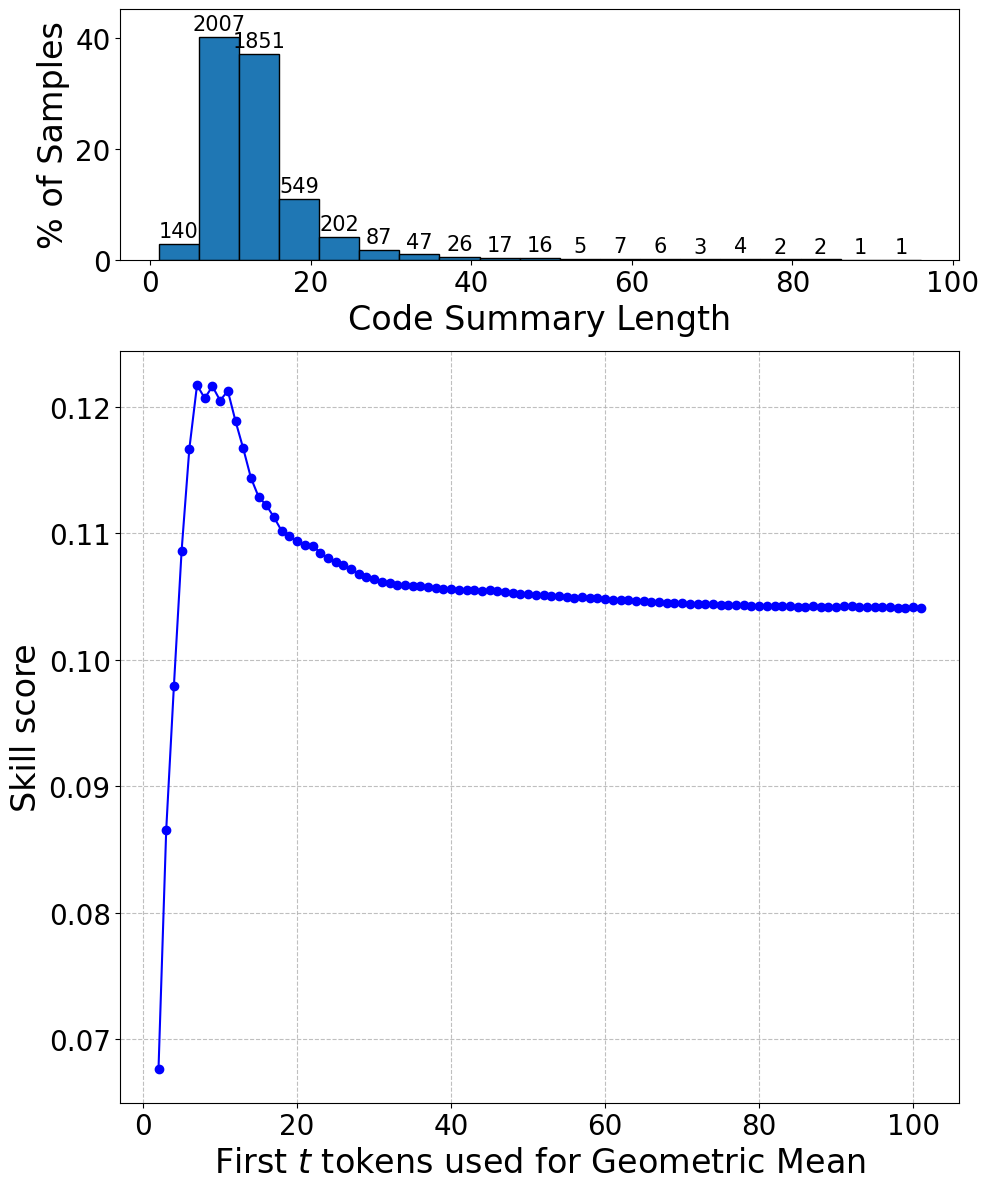

Java gpt-3.5-turbo ASAP


<Figure size 640x480 with 0 Axes>

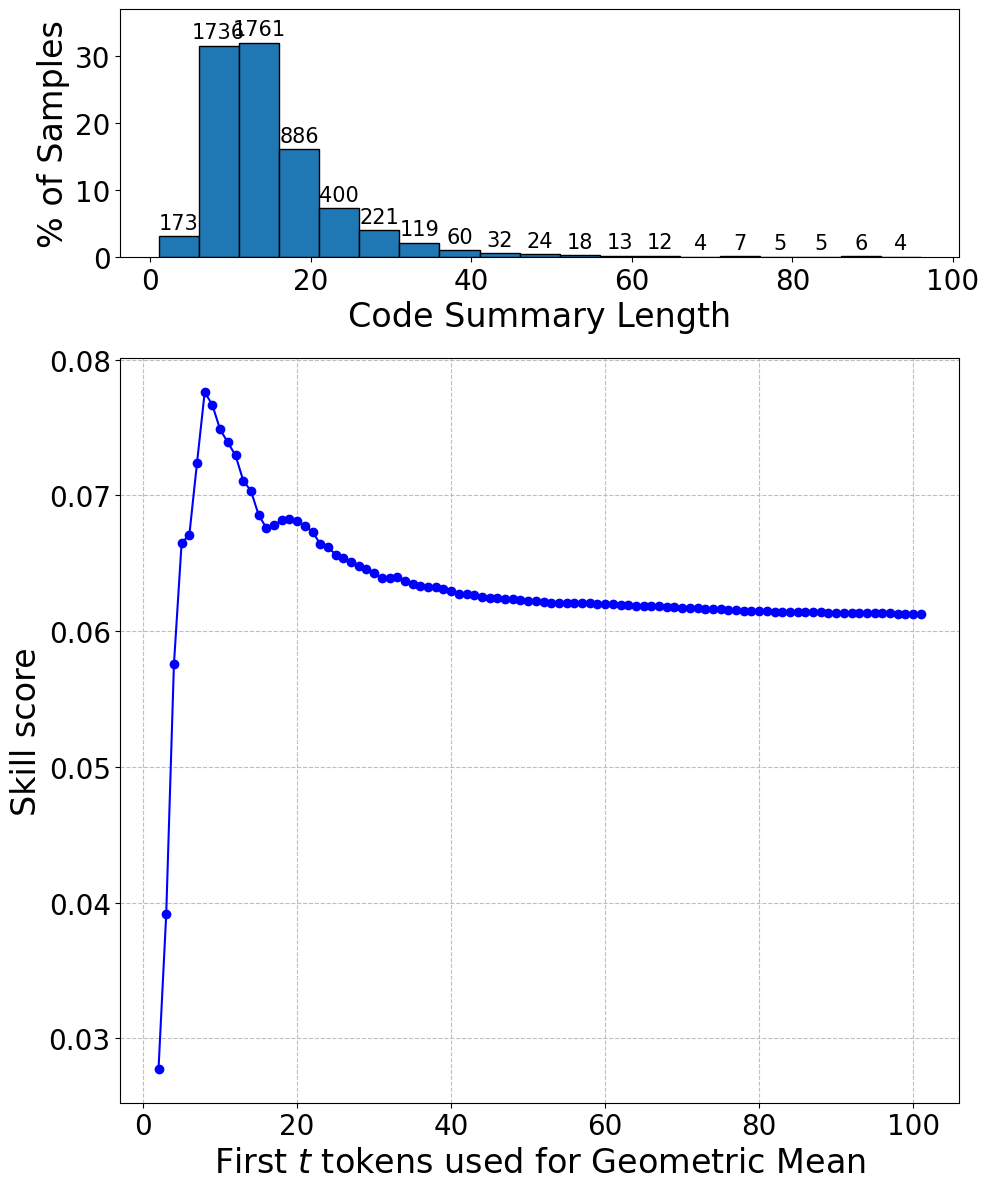

Java gpt-3.5-turbo BM25


<Figure size 640x480 with 0 Axes>

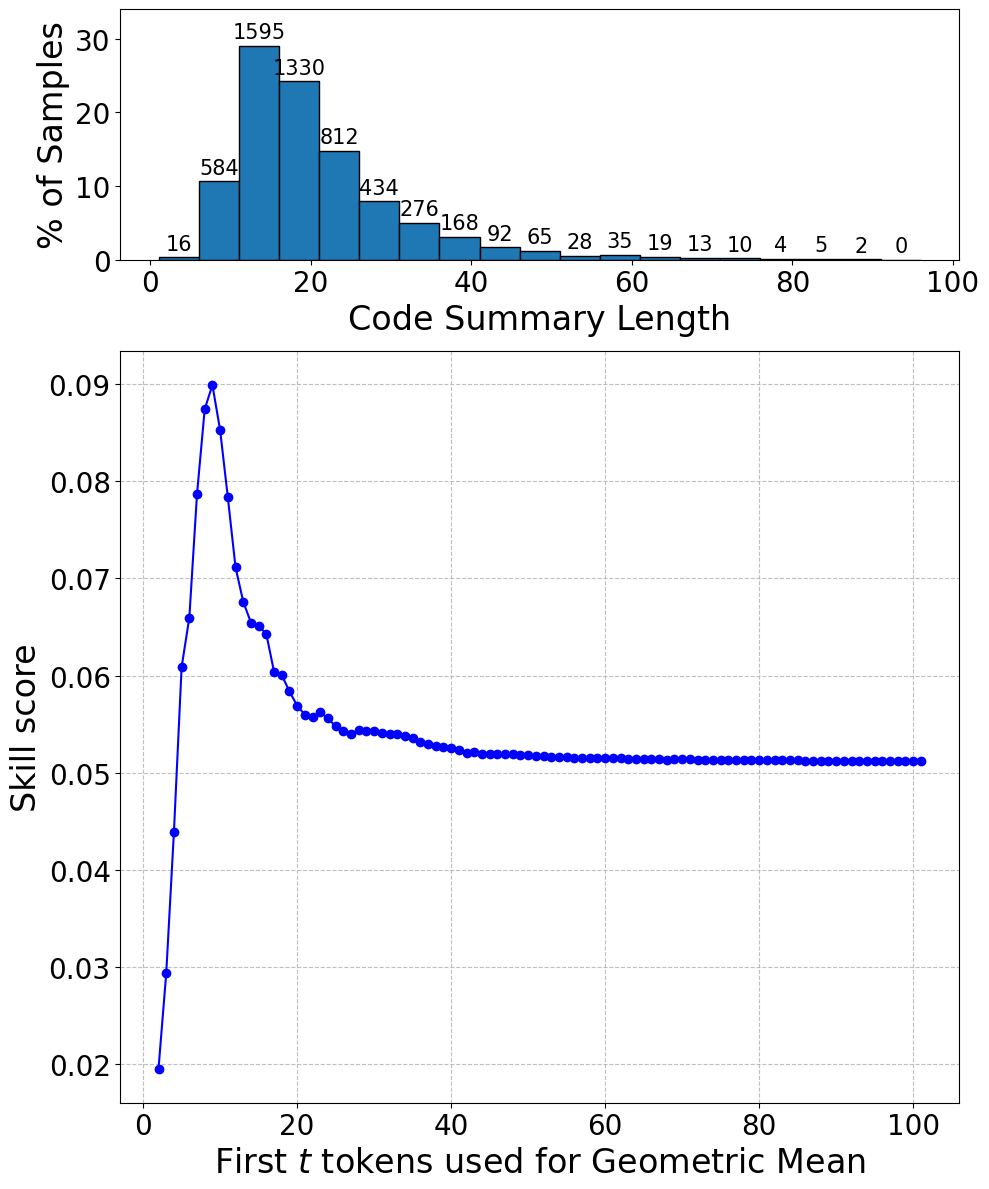

Java deepseek-coder-33b-instruct ASAP


<Figure size 640x480 with 0 Axes>

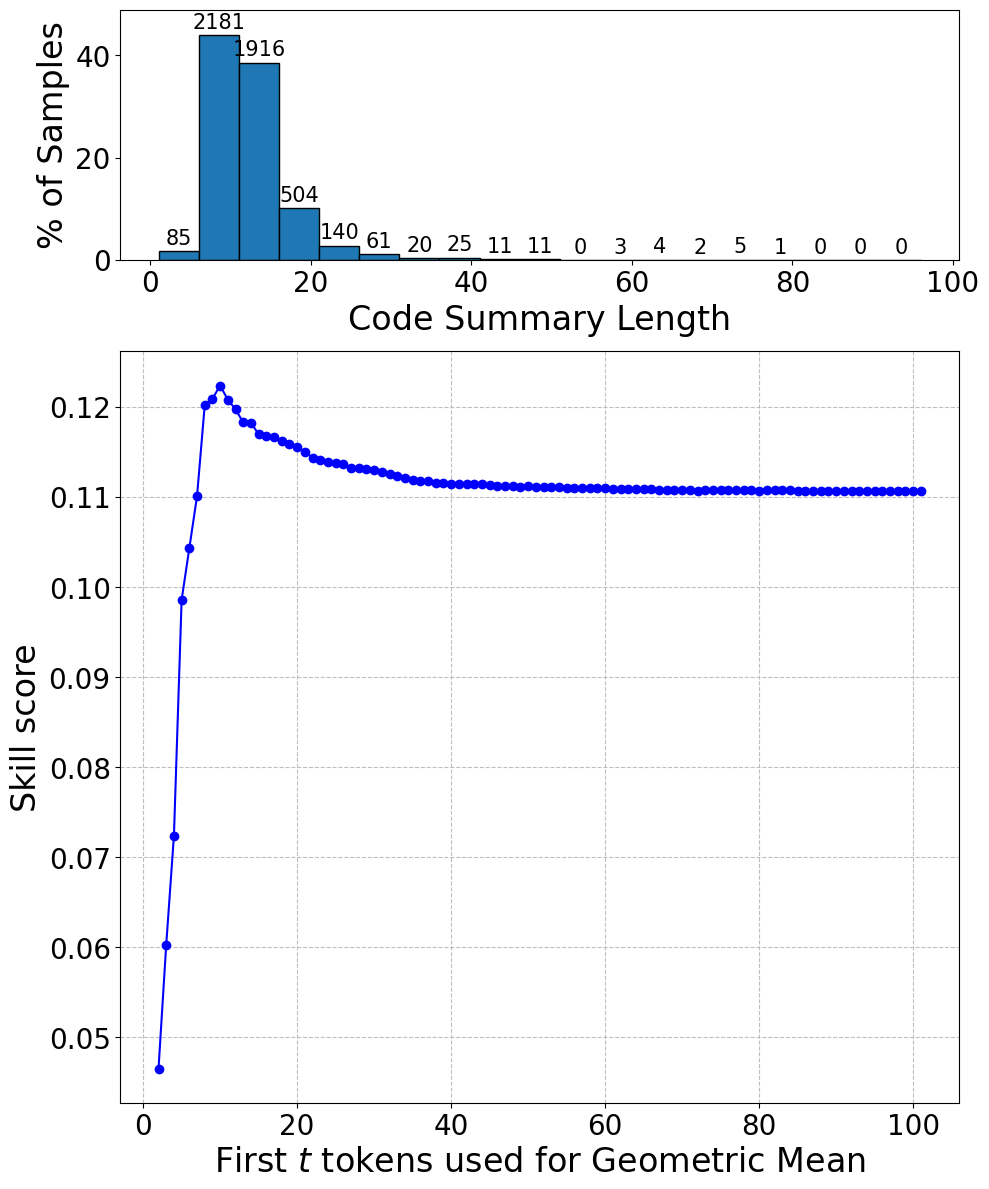

Java deepseek-coder-33b-instruct BM25


<Figure size 640x480 with 0 Axes>

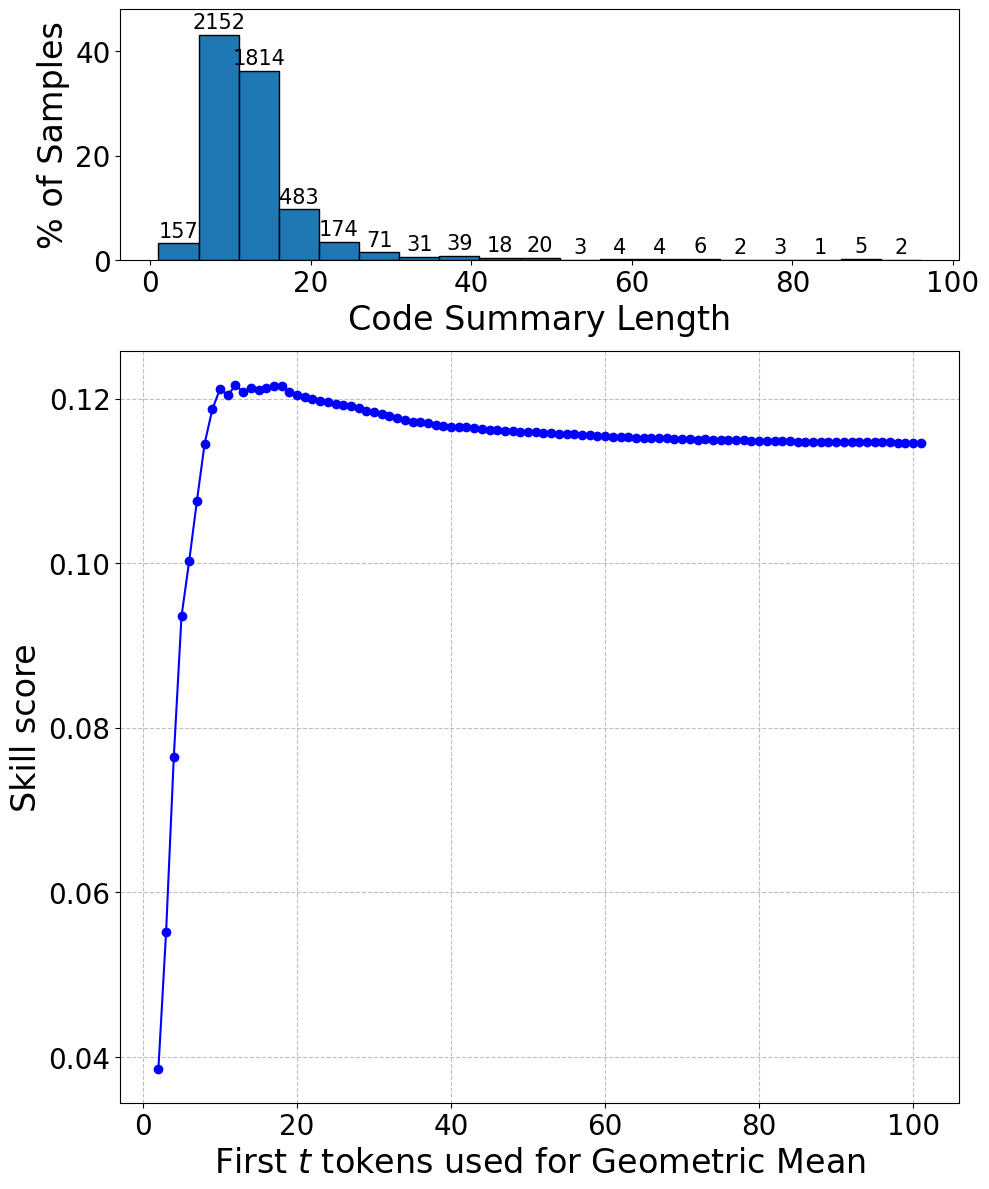

<Figure size 640x480 with 0 Axes>

In [17]:
# for language in dfs:
#     for model in dfs[language]:
#         for method in dfs[language][model]:
#             print(language, model, method)
#             plt.figure(figsize=(10, 6))
#             all_summary_lengths_scaled_df = dfs[language][model][method]["scaled_calib"][dfs[language][model][method]["scaled_calib"]["length_range"] == "(0, 100)"]
#             plt.plot(all_summary_lengths_scaled_df['token_position'] + 1, all_summary_lengths_scaled_df['Skill score'], marker='o', linestyle='-', color='b', label='Skill score')
#             plt.xlabel('Token Position Cutoff')
#             plt.ylabel('Skill score')
#             plt.title('Scaled Token Probabilities: Skill score vs. Token Position Cutoff')
#             plt.grid(True, linestyle='--', alpha=0.7)
#             plt.legend()
#             plt.tight_layout()
#             plt.show()
import matplotlib.gridspec as gridspec

for language in dfs:
    for model in dfs[language]:
        for method in dfs[language][model]:
            print(language, model, method)
            fig = plt.figure(figsize=(10, 12)) # Create a figure with two subplots vertically
            gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3])  # Define a grid with 2 rows and 1 column, with different heights

            # Sample Distribution: # Samples containing each token position
            ax0 = plt.subplot(gs[0])
            all_summary_lengths_scaled_df = dfs[language][model][method]["scaled_calib"]
            # sample_sizes = prob_info[language][f"{model}_{method}"]["sample_sizes"]
            # print(dfs[language][model][method])
            # Get the lengths data
            lengths = prob_info[language][f"{model}_{method}"]["lengths"]
            
            # Calculate the distribution
            hist, bins = np.histogram(lengths, bins=range(1, 101, 5))
            
            # Convert to percentage
            hist_percentage = hist / len(lengths) * 100
            
            # Plot the distribution as a histogram
            ax0.hist(lengths, bins=range(1, 101, 5), weights=np.ones(len(lengths)) / len(lengths) * 100, alpha=1, edgecolor='black')
            ax0.set_xlabel("Code Summary Length", fontsize=24)
            ax0.set_ylabel("% of Samples", fontsize=24)
            ax0.set_ylim(0, max(hist_percentage) + 5)
            
            # Label the sample sizes for each summary length bin
            for i in range(len(hist)):
                ax0.text(bins[i] + 2.5, hist_percentage[i] + 0.5, str(hist[i]), ha='center', va='bottom', fontsize=15, color='black')
            ax0.tick_params(labelsize=20)
            # Skill Score Plot
            ax1 = plt.subplot(gs[1])
            ax1.plot(all_summary_lengths_scaled_df['token_position'] + 1, all_summary_lengths_scaled_df['Skill score'], marker='o', linestyle='-', color='b', label='Skill score')
            ax1.set_xlabel('First $t$ tokens used for Geometric Mean', fontsize=24)
            ax1.set_ylabel('Skill score', fontsize=24)
            ax1.grid(True, linestyle='--', alpha=0.8)
            ax1.tick_params(labelsize=20)
            # ax1.legend(loc='upper left')

            fig.tight_layout()
            plt.show()
            plt.savefig(f"./{language}_{model}_{method}_skill_score_vs_token_position_cutoff.png")